In [2]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scipy

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
# --- Load and Clean Data ---
# Load Sales_Data.csv
sales_df = pd.read_csv('Sales_Data.csv')
sales_df = sales_df.drop(columns=['STT'])  # Drop unnecessary column
sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%m/%d/%Y')
sales_df['New_Sales'] = sales_df['New_Sales'].astype(float)

# Load Promotion.csv
promo_df = pd.read_csv('Promotion.csv')
promo_df['Active_Month'] = pd.to_datetime(promo_df['Active_Month'], format='%Y-%m')
promo_df = promo_df.rename(columns={'Active_Month': 'Date'})

# Check for duplicates and missing values
print("Sales duplicates:", sales_df.duplicated().sum())
print("Promo duplicates:", promo_df.duplicated().sum())
print("Sales missing values:\n", sales_df.isnull().sum())
print("Promo missing values:\n", promo_df.isnull().sum())

Sales duplicates: 0
Promo duplicates: 0
Sales missing values:
 Date         0
New_Sales    0
dtype: int64
Promo missing values:
 Promo_ID      0
Date          0
Promo_Type    0
Budget_USD    0
dtype: int64


In [4]:
# --- Merge Datasets ---
# Merge datasets on Date
merged_df = sales_df.merge(promo_df, on='Date', how='left')

# Apply convention: no budget -> Budget_USD = 0, Promo_Type = 'Non_Promo'
merged_df['Budget_USD'] = merged_df['Budget_USD'].fillna(0)
merged_df['Promo_Type'] = merged_df['Promo_Type'].fillna('Non_Promo')
merged_df['Promo_ID'] = merged_df['Promo_ID'].fillna('None')

# Create Is_Promotion column
merged_df['Is_Promotion'] = (merged_df['Budget_USD'] > 0).astype(int)

# Remove rows with missing sales data
merged_df = merged_df.dropna(subset=['New_Sales'])

# Set Date as index and sort
merged_df = merged_df.set_index('Date').sort_index()

# Verify convention: Sample merged data
print("\nSample of Merged Data (showing Budget_USD and Promo_Type):")
print(merged_df[['New_Sales', 'Budget_USD', 'Promo_Type', 'Is_Promotion']].head(10))
print("\nPromo_Type Value Counts:")
print(merged_df['Promo_Type'].value_counts())


Sample of Merged Data (showing Budget_USD and Promo_Type):
              New_Sales  Budget_USD Promo_Type  Is_Promotion
Date                                                        
1995-01-01   801.087735         0.0  Non_Promo             0
1995-02-01  1109.019328      7000.0     Bundle             1
1995-03-01   876.561180         0.0  Non_Promo             0
1995-04-01   890.258213         0.0  Non_Promo             0
1995-05-01   774.015130         0.0  Non_Promo             0
1995-06-01   704.132310         0.0  Non_Promo             0
1995-07-01   701.413868         0.0  Non_Promo             0
1995-08-01   907.925961     22000.0     Bundle             1
1995-09-01   555.652281         0.0  Non_Promo             0
1995-10-01   611.859034         0.0  Non_Promo             0

Promo_Type Value Counts:
Promo_Type
Non_Promo    306
Bundle        28
Discount      23
Cashback       3
Name: count, dtype: int64


In [5]:
# --- Feature Engineering ---
# Basic time features
merged_df['Year'] = merged_df.index.year
merged_df['Month_Num'] = merged_df.index.month
merged_df['Month_Name'] = merged_df.index.strftime('%b')
merged_df['Quarter'] = merged_df.index.quarter

# Months since last promotion
merged_df['Months_Since_Last_Promo'] = 0
last_promo = 0
for i, row in merged_df.iterrows():
    if row['Is_Promotion'] == 1:
        merged_df.at[i, 'Months_Since_Last_Promo'] = 0
        last_promo = 0
    else:
        last_promo += 1
        merged_df.at[i, 'Months_Since_Last_Promo'] = last_promo

# Consecutive promotion months
merged_df['Promo_Active_Consecutive_Months'] = 0
consecutive = 0
for i, row in merged_df.iterrows():
    if row['Is_Promotion'] == 1:
        consecutive += 1
    else:
        consecutive = 0
    merged_df.at[i, 'Promo_Active_Consecutive_Months'] = consecutive

# Dummy variables for months and quarters
month_dummies = pd.get_dummies(merged_df['Month_Name'], prefix='Month')
quarter_dummies = pd.get_dummies(merged_df['Quarter'], prefix='Quarter')
merged_df = pd.concat([merged_df, month_dummies, quarter_dummies], axis=1)

In [6]:
merged_df.head()


,New_Sales,Promo_ID,Promo_Type,Budget_USD,Is_Promotion,Year,Month_Num,Month_Name,Quarter,Months_Since_Last_Promo,...,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Quarter_1,Quarter_2,Quarter_3,Quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-01,801.087735,None,Non_Promo,0.0,0,1995,1,Jan,1,1,...,False,False,False,False,False,False,True,False,False,False
1995-02-01,1109.019328,P001,Bundle,7000.0,1,1995,2,Feb,1,0,...,False,False,False,False,False,False,True,False,False,False
1995-03-01,876.561180,None,Non_Promo,0.0,0,1995,3,Mar,1,1,...,False,True,False,False,False,False,True,False,False,False
1995-04-01,890.258213,None,Non_Promo,0.0,0,1995,4,Apr,2,2,...,False,False,False,False,False,False,False,True,False,False
1995-05-01,774.015130,None,Non_Promo,0.0,0,1995,5,May,2,3,...,False,False,True,False,False,False,False,True,False,False


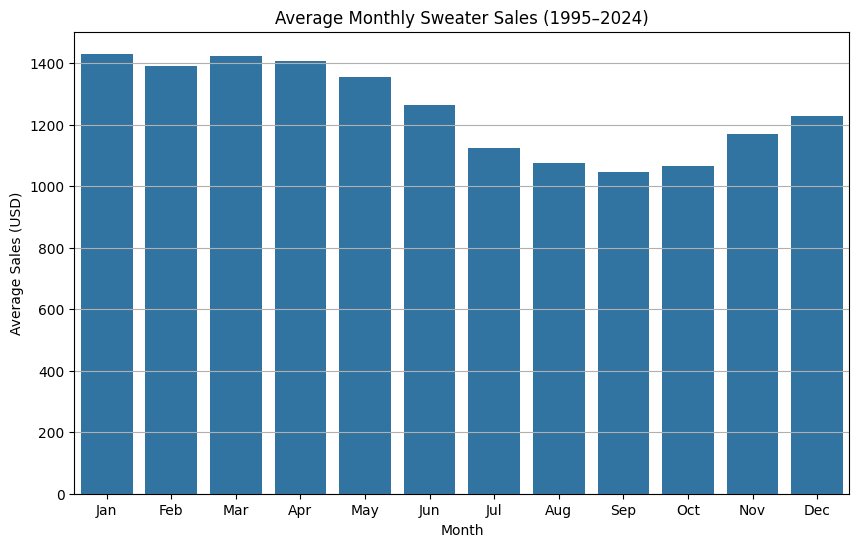


Average Sales by Month (USD):
 Month_Name
Jan    1430.86
Feb    1391.41
Mar    1422.18
Apr    1408.10
May    1355.72
Jun    1263.65
Jul    1123.23
Aug    1074.25
Sep    1044.82
Oct    1066.44
Nov    1169.78
Dec    1229.32
Name: New_Sales, dtype: float64


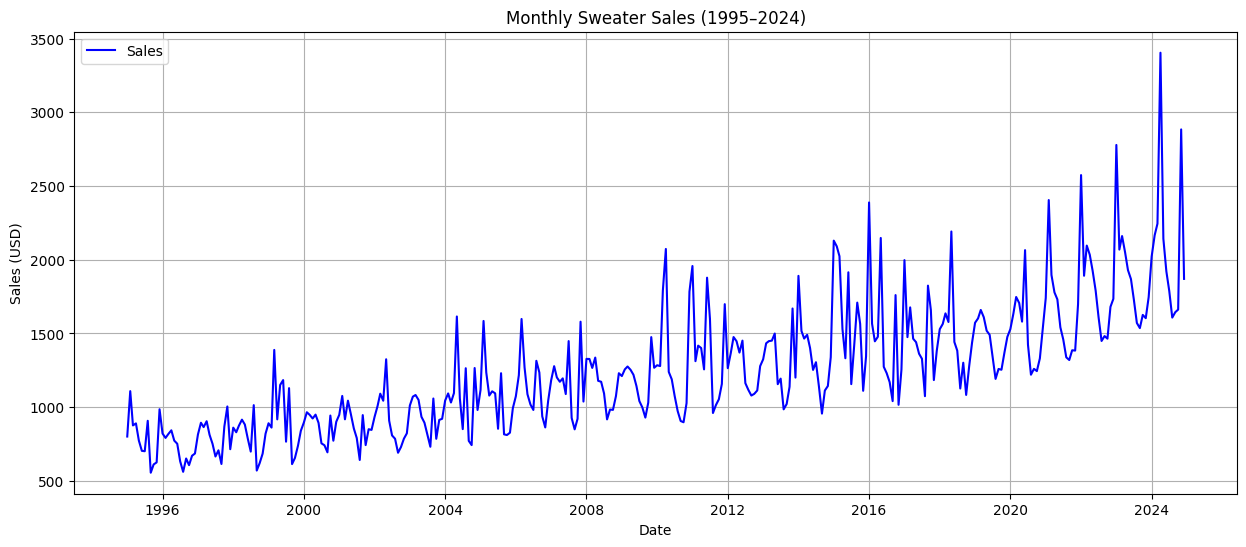

In [7]:
# --- Sales Visualizations ---
# Average Monthly Sales (Bar Plot)
sales_df['Month_Name'] = sales_df['Date'].dt.strftime('%b')
monthly_avg = sales_df.groupby('Month_Name')['New_Sales'].mean().reindex(
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title('Average Monthly Sweater Sales (1995–2024)')
plt.xlabel('Month')
plt.ylabel('Average Sales (USD)')
plt.grid(axis='y')
plt.show()
print("\nAverage Sales by Month (USD):\n", monthly_avg.round(2))

# Monthly Sales (Line Plot)
sales_df = sales_df.sort_values('Date')
plt.figure(figsize=(15, 6))
plt.plot(sales_df['Date'], sales_df['New_Sales'], label='Sales', color='blue')
plt.title('Monthly Sweater Sales (1995–2024)')
plt.xlabel('Date')
plt.ylabel('Sales (USD)')
plt.grid(True)
plt.legend()
plt.show()


In [8]:
# --- Deeper EDA: Univariate Analysis ---
# Sales
sales_cols = ['New_Sales']
print("\nSales Statistics:")
print(merged_df[sales_cols].describe())
print("\nSkewness:", merged_df[sales_cols].skew())
print("\nKurtosis:", merged_df[sales_cols].kurtosis())


Sales Statistics:
         New_Sales
count   360.000000
mean   1248.313259
std     427.471129
min     555.652281
25%     920.482311
50%    1184.039228
75%    1479.066273
max    3404.428595

Skewness: New_Sales    1.074862
dtype: float64

Kurtosis: New_Sales    2.028215
dtype: float64


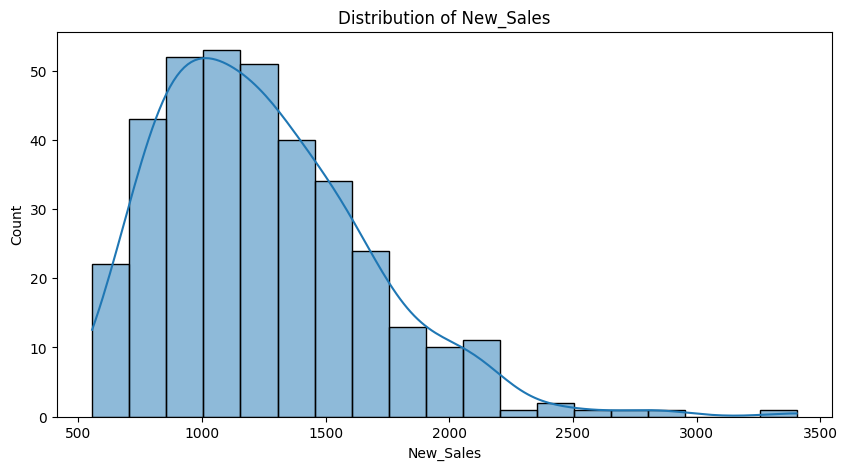

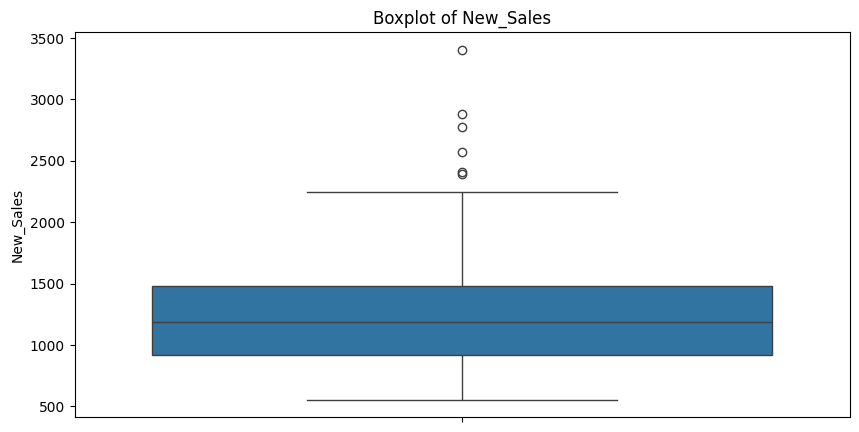

In [9]:
# Visualizations for Sales
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['New_Sales'], kde=True)
plt.title('Distribution of New_Sales')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(y=merged_df['New_Sales'])
plt.title('Boxplot of New_Sales')
plt.show()

In [10]:
# Budget (where Budget > 0)
budget_cols = ['Budget_USD']
budget_data = merged_df[merged_df['Budget_USD'] > 0][budget_cols]
print("\nBudget Statistics (where Budget > 0):")
print(budget_data.describe())
print("\nSkewness:", budget_data.skew())
print("\nKurtosis:", budget_data.kurtosis())


Budget Statistics (where Budget > 0):
         Budget_USD
count     54.000000
mean   14462.962963
std     5999.097300
min     5000.000000
25%     8000.000000
50%    16000.000000
75%    20000.000000
max    24000.000000

Skewness: Budget_USD   -0.087808
dtype: float64

Kurtosis: Budget_USD   -1.455299
dtype: float64


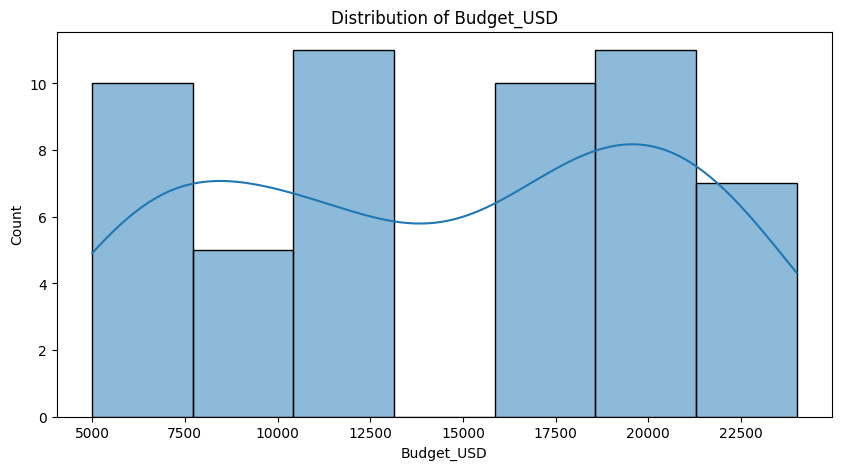

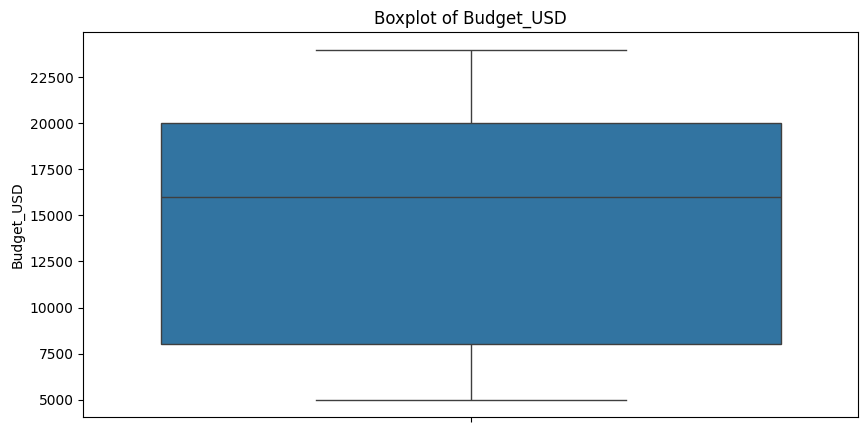

In [11]:
# Visualizations for Budget
plt.figure(figsize=(10, 5))
sns.histplot(budget_data['Budget_USD'], kde=True)
plt.title('Distribution of Budget_USD')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(y=budget_data['Budget_USD'])
plt.title('Boxplot of Budget_USD')
plt.show()

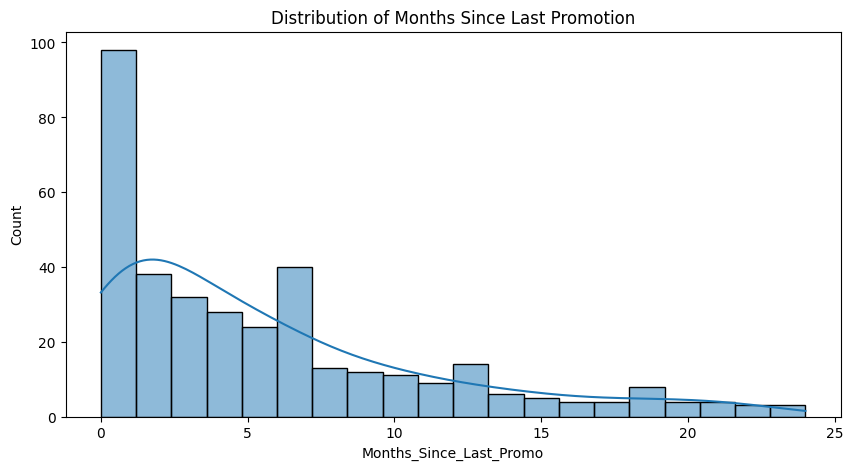

In [12]:
# Months since last promo
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['Months_Since_Last_Promo'], bins=20, kde=True)
plt.title('Distribution of Months Since Last Promotion')
plt.show()

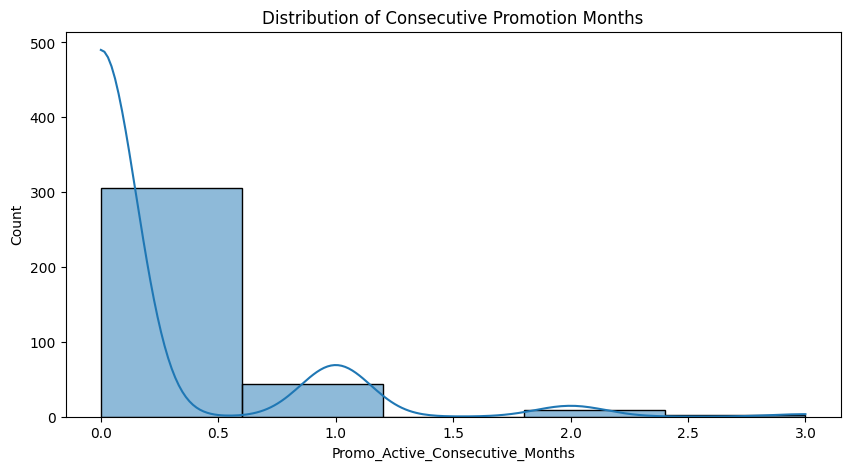

In [13]:
# Consecutive promo months
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['Promo_Active_Consecutive_Months'], bins=5, kde=True)
plt.title('Distribution of Consecutive Promotion Months')
plt.show()


Promotion Type Frequencies:
 Promo_Type
Non_Promo    306
Bundle        28
Discount      23
Cashback       3
Name: count, dtype: int64

Promotion Type Percentages:
 Promo_Type
Non_Promo    85.000000
Bundle        7.777778
Discount      6.388889
Cashback      0.833333
Name: proportion, dtype: float64


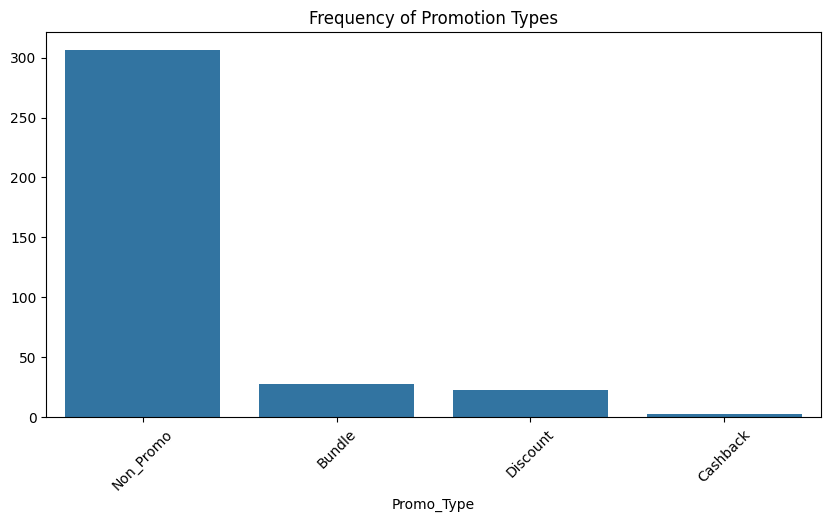

In [14]:
# Promotion types
promo_counts = merged_df['Promo_Type'].value_counts()
promo_percent = merged_df['Promo_Type'].value_counts(normalize=True) * 100
print("\nPromotion Type Frequencies:\n", promo_counts)
print("\nPromotion Type Percentages:\n", promo_percent)

plt.figure(figsize=(10, 5))
sns.barplot(x=promo_counts.index, y=promo_counts.values)
plt.title('Frequency of Promotion Types')
plt.xticks(rotation=45)
plt.show()

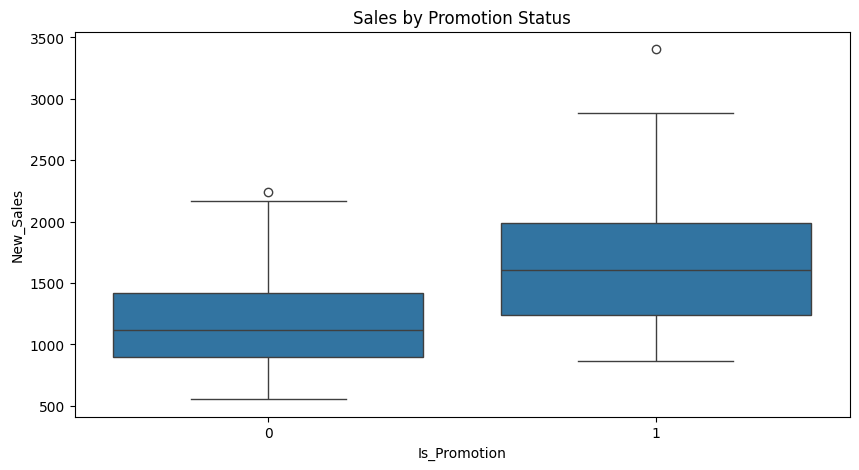

In [15]:
# --- Deeper EDA: Multivariate Analysis ---
# Sales by promotion status
plt.figure(figsize=(10, 5))
sns.boxplot(x='Is_Promotion', y='New_Sales', data=merged_df)
plt.title('Sales by Promotion Status')
plt.show()

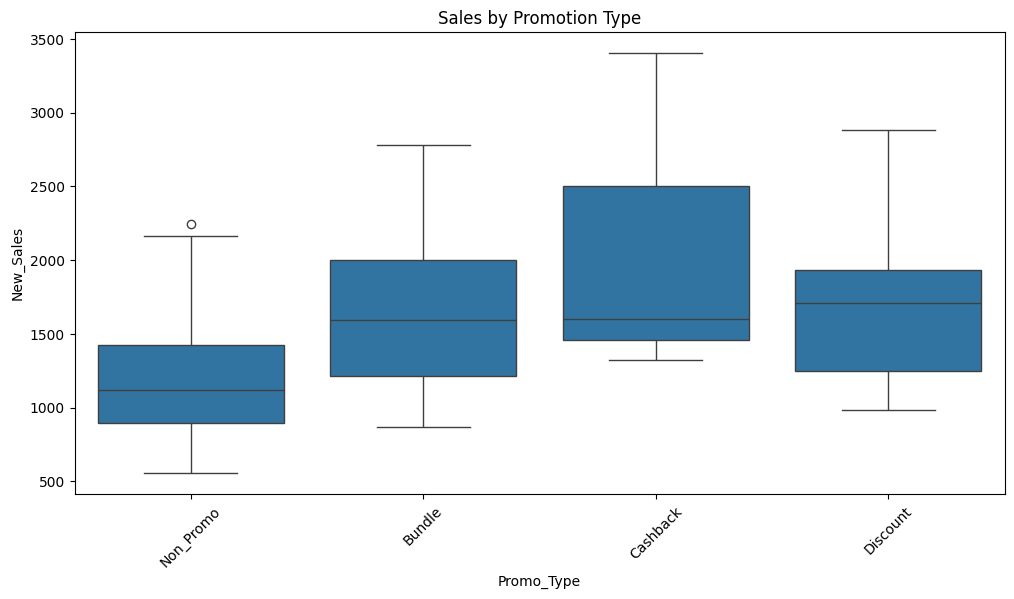

In [16]:
# Sales by promotion type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Promo_Type', y='New_Sales', data=merged_df, order=merged_df.groupby('Promo_Type')['New_Sales'].median().sort_values().index)
plt.title('Sales by Promotion Type')
plt.xticks(rotation=45)
plt.show()

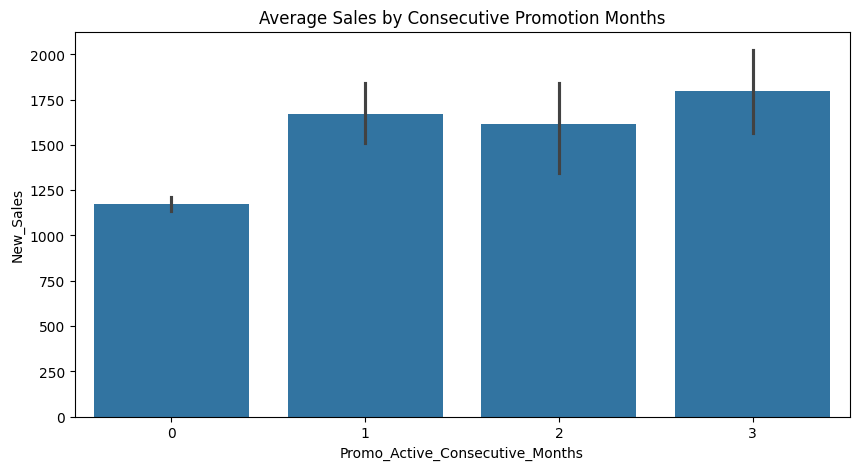

In [17]:
# Sales by consecutive promo months
plt.figure(figsize=(10, 5))
sns.barplot(x='Promo_Active_Consecutive_Months', y='New_Sales', data=merged_df)
plt.title('Average Sales by Consecutive Promotion Months')
plt.show()

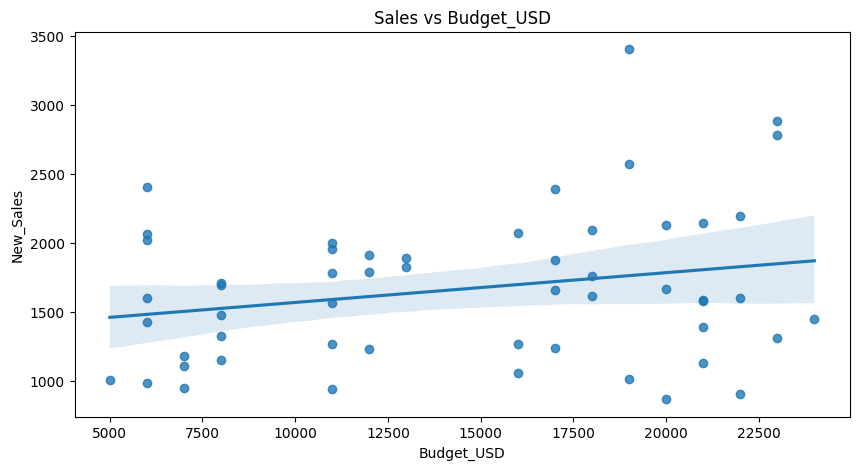

In [18]:
# Sales vs Budget
budget_data = merged_df[merged_df['Budget_USD'] > 0]
plt.figure(figsize=(10, 5))
sns.regplot(x='Budget_USD', y='New_Sales', data=budget_data)
plt.title('Sales vs Budget_USD')
plt.show()

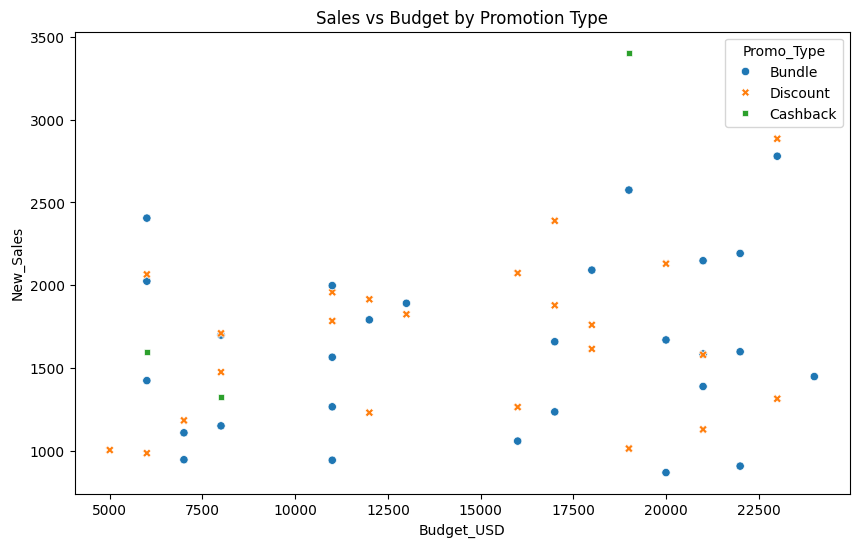

In [19]:
# Sales vs Budget by Promo Type
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Budget_USD', y='New_Sales', hue='Promo_Type', style='Promo_Type', data=budget_data)
plt.title('Sales vs Budget by Promotion Type')
plt.show()

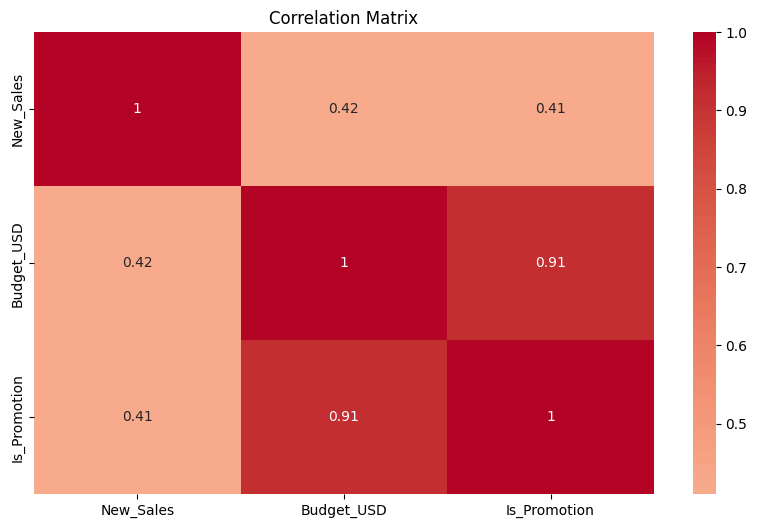

In [20]:
# Correlation matrix
corr_cols = ['New_Sales', 'Budget_USD', 'Is_Promotion']
plt.figure(figsize=(10, 6))
sns.heatmap(merged_df[corr_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

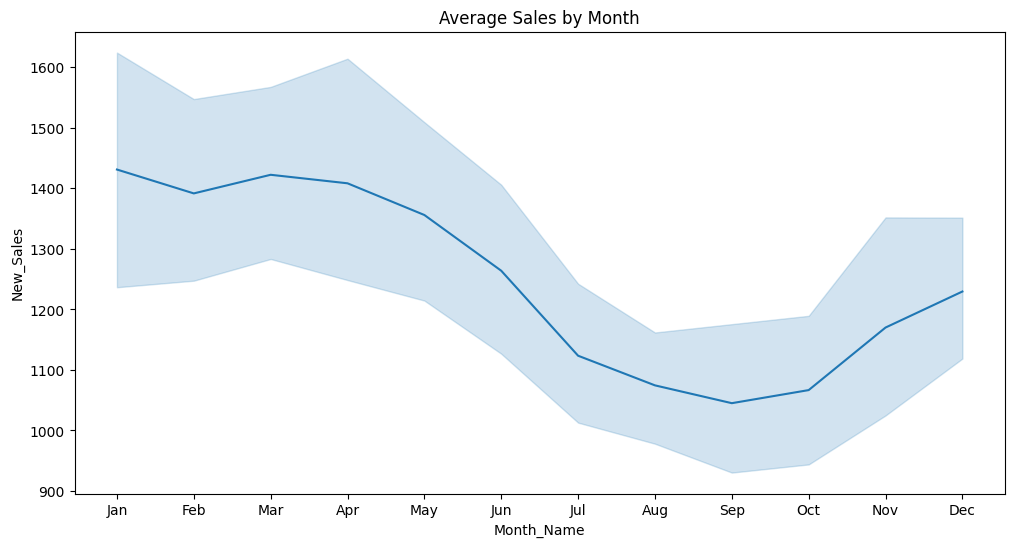

In [21]:
# --- Deeper EDA: Seasonal Analysis ---
# Sales by month
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month_Name', y='New_Sales', data=merged_df, estimator='mean')
plt.title('Average Sales by Month')
plt.show()

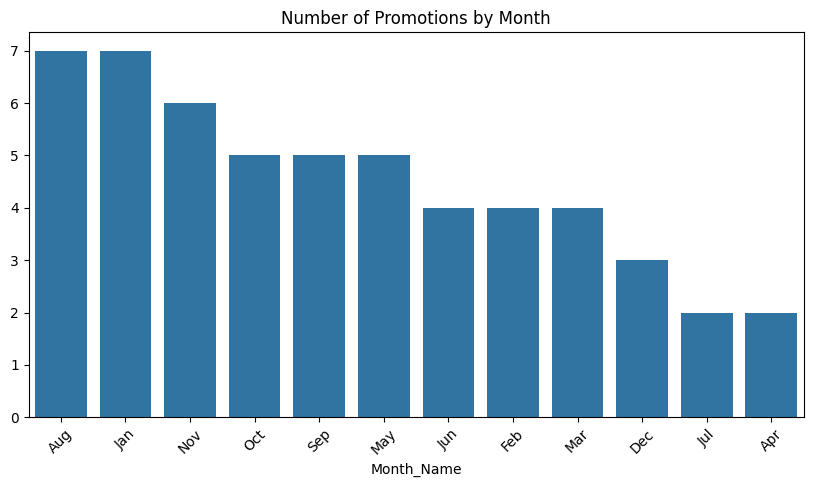

In [22]:
# Promotion frequency by month
promo_by_month = merged_df[merged_df['Is_Promotion'] == 1]['Month_Name'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=promo_by_month.index, y=promo_by_month.values)
plt.title('Number of Promotions by Month')
plt.xticks(rotation=45)
plt.show()

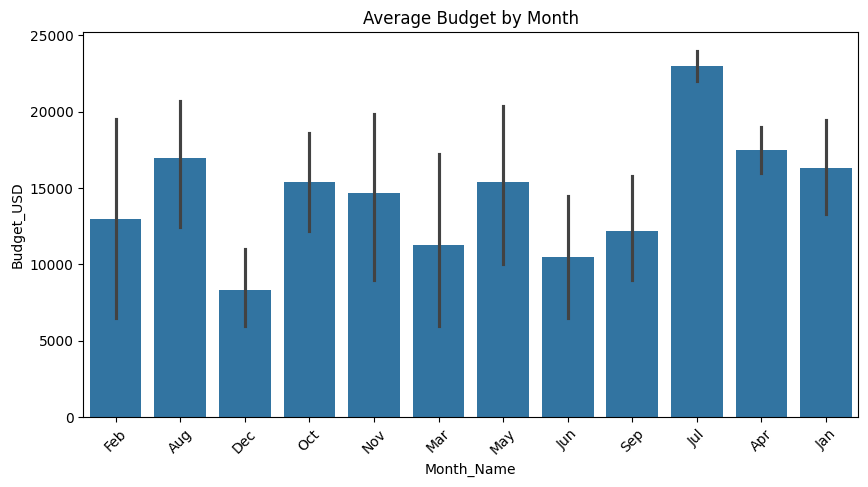

In [23]:
# Budget by month
plt.figure(figsize=(10, 5))
sns.barplot(x='Month_Name', y='Budget_USD', data=merged_df[merged_df['Budget_USD'] > 0], estimator='mean')
plt.title('Average Budget by Month')
plt.xticks(rotation=45)
plt.show()

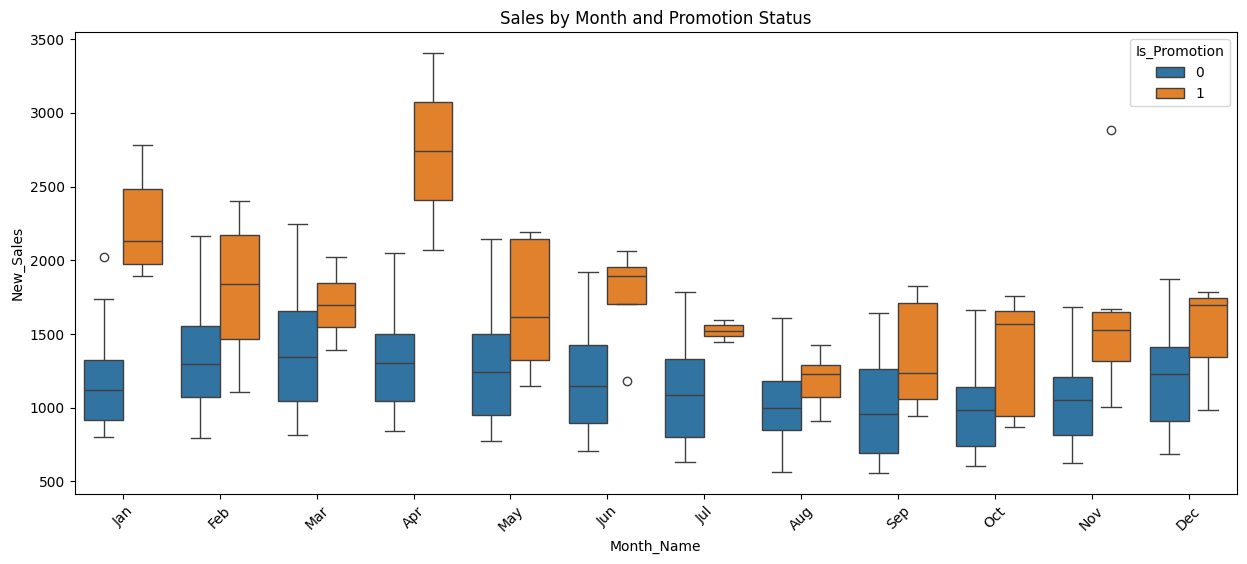

In [24]:
# Sales by month and promotion status
plt.figure(figsize=(15, 6))
sns.boxplot(x='Month_Name', y='New_Sales', hue='Is_Promotion', data=merged_df)
plt.title('Sales by Month and Promotion Status')
plt.xticks(rotation=45)
plt.show()

In [25]:
# --- Deeper EDA: Time-Period Comparative Analysis ---
# Define periods
merged_df['Period'] = np.where(merged_df.index.year <= 2004, 'Early (1995-2004)', 'Recent (2005-2024)')


Sales Statistics by Period:
                    count         mean         std         min          25%  \
Period                                                                        
Early (1995-2004)   120.0   870.854299  179.054612  555.652281   749.321383   
Recent (2005-2024)  240.0  1437.042739  388.861003  811.337819  1168.328787   

                            50%          75%          max  
Period                                                     
Early (1995-2004)    858.447044   950.643521  1615.421425  
Recent (2005-2024)  1368.578976  1627.958871  3404.428595  


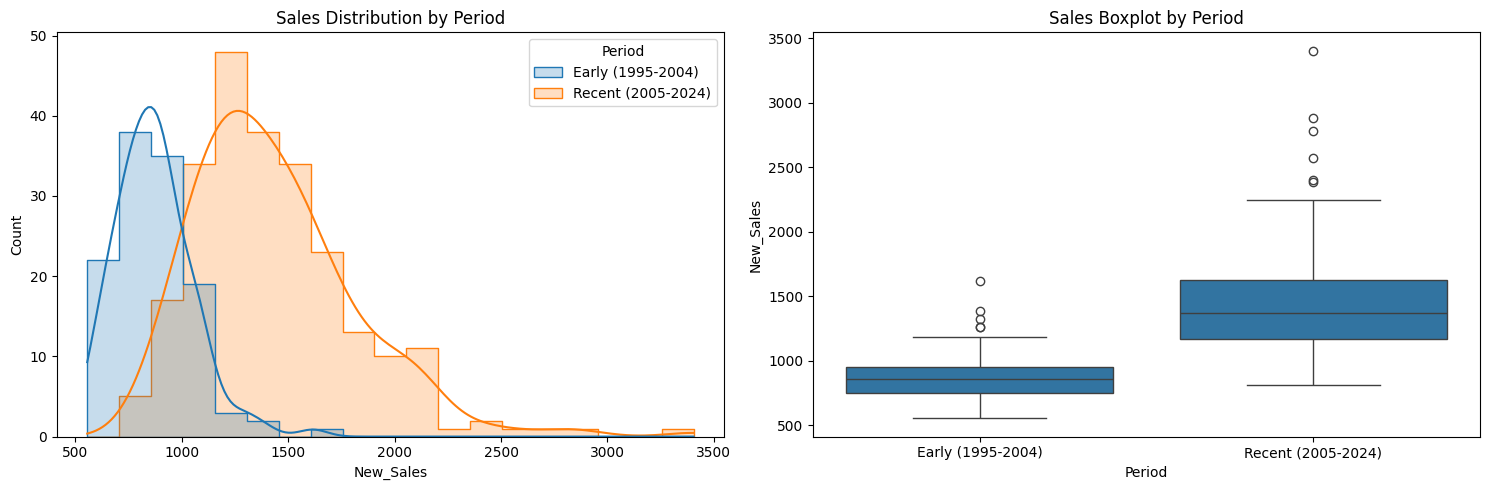

In [26]:
# Sales comparison
print("\nSales Statistics by Period:")
print(merged_df.groupby('Period')['New_Sales'].describe())

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=merged_df, x='New_Sales', hue='Period', kde=True, element='step')
plt.title('Sales Distribution by Period')
plt.subplot(1, 2, 2)
sns.boxplot(x='Period', y='New_Sales', data=merged_df)
plt.title('Sales Boxplot by Period')
plt.tight_layout()
plt.show()


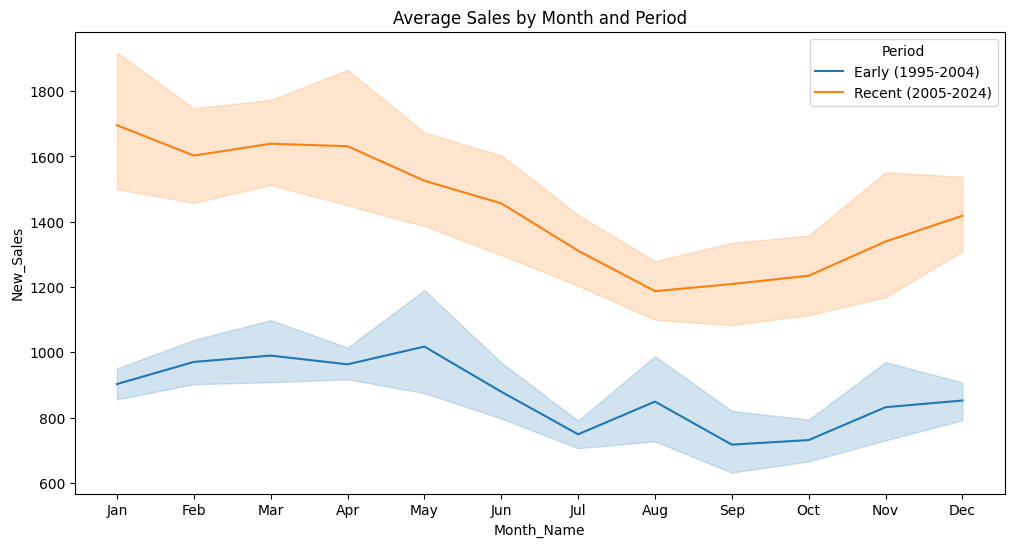

In [27]:
# Seasonal pattern comparison
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month_Name', y='New_Sales', hue='Period', data=merged_df, estimator='mean')
plt.title('Average Sales by Month and Period')
plt.show()

In [28]:
# Promotion frequency
promo_freq = merged_df.groupby('Period')['Is_Promotion'].mean() * 12  # Average promotions per year
print("\nAverage Promotions per Year by Period:\n", promo_freq)


Average Promotions per Year by Period:
 Period
Early (1995-2004)     1.70
Recent (2005-2024)    1.85
Name: Is_Promotion, dtype: float64



Promotion Type Distribution (%):
 Promo_Type            Bundle  Cashback  Discount  Non_Promo
Period                                                     
Early (1995-2004)   7.500000  0.833333  5.833333  85.833333
Recent (2005-2024)  7.916667  0.833333  6.666667  84.583333


<Figure size 1200x600 with 0 Axes>

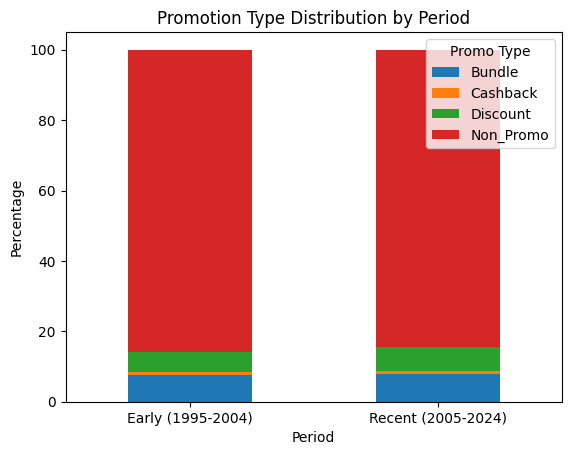

In [29]:
# Promotion types
promo_type_dist = merged_df.groupby(['Period', 'Promo_Type']).size().unstack().fillna(0)
promo_type_dist = promo_type_dist.div(promo_type_dist.sum(axis=1), axis=0) * 100
print("\nPromotion Type Distribution (%):\n", promo_type_dist)

plt.figure(figsize=(12, 6))
promo_type_dist.plot(kind='bar', stacked=True)
plt.title('Promotion Type Distribution by Period')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Promo Type')
plt.show()

In [30]:
# Budget comparison
budget_stats = merged_df[merged_df['Budget_USD'] > 0].groupby('Period')['Budget_USD'].describe()
print("\nBudget Statistics by Period (where Budget > 0):\n", budget_stats)


Budget Statistics by Period (where Budget > 0):
                     count          mean          std     min      25%  \
Period                                                                  
Early (1995-2004)    17.0  13117.647059  6203.651676  5000.0   7000.0   
Recent (2005-2024)   37.0  15081.081081  5884.907147  6000.0  11000.0   

                        50%      75%      max  
Period                                         
Early (1995-2004)   11000.0  19000.0  22000.0  
Recent (2005-2024)  17000.0  20000.0  24000.0  


In [31]:
# Promotion impact
promo_impact = merged_df.groupby(['Period', 'Is_Promotion'])['New_Sales'].mean().unstack()
promo_impact['Impact'] = promo_impact[1] - promo_impact[0]
print("\nPromotion Impact by Period:\n", promo_impact)



Promotion Impact by Period:
 Is_Promotion                  0            1      Impact
Period                                                  
Early (1995-2004)    828.531524  1127.280523  298.748999
Recent (2005-2024)  1350.429442  1912.245426  561.815984


In [32]:
# Promotion type impact
promo_type_impact = merged_df.groupby(['Period', 'Promo_Type'])['New_Sales'].mean().unstack()
print("\nSales by Promotion Type and Period:\n", promo_type_impact)


Sales by Promotion Type and Period:
 Promo_Type               Bundle     Cashback     Discount    Non_Promo
Period                                                                
Early (1995-2004)   1071.138952  1325.174995  1171.191904   828.531524
Recent (2005-2024)  1883.038591  2501.453874  1873.277487  1350.429442


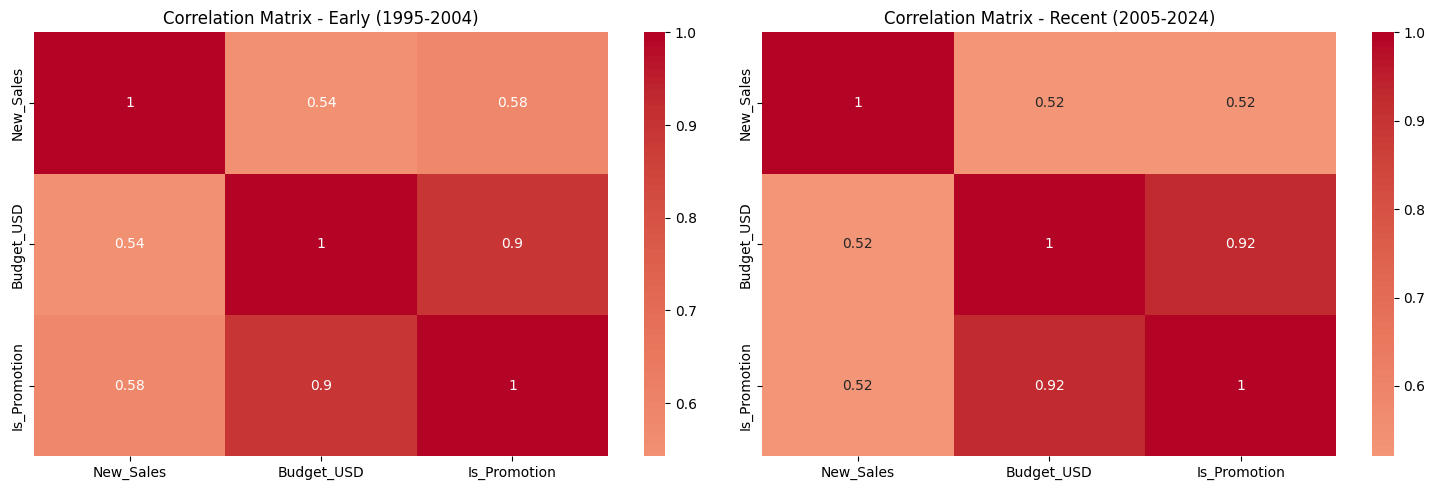

In [33]:
# Correlation comparison
corr_cols = ['New_Sales', 'Budget_USD', 'Is_Promotion']
plt.figure(figsize=(15, 5))
for i, period in enumerate(merged_df['Period'].unique(), 1):
    plt.subplot(1, 2, i)
    sns.heatmap(merged_df[merged_df['Period'] == period][corr_cols].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title(f'Correlation Matrix - {period}')
plt.tight_layout()
plt.show()

In [34]:
# --- Three-Period Comparative Analysis (1995–2004, 2005–2014, 2015–2024) ---
# Define three periods
merged_df['Period'] = pd.cut(merged_df['Year'],
                            bins=[1994, 2004, 2014, 2024],
                            labels=['Early (1995–2004)', 'Middle (2005–2014)', 'Recent (2015–2024)'],
                            include_lowest=True)

# Sales comparison
print("\nSales Statistics by Period:")
print(merged_df.groupby('Period')['New_Sales'].describe())


Sales Statistics by Period:
                    count         mean         std          min          25%  \
Period                                                                         
Early (1995–2004)   120.0   870.854299  179.054612   555.652281   749.321383   
Middle (2005–2014)  120.0  1227.259840  249.840747   811.337819  1051.077908   
Recent (2015–2024)  120.0  1646.825639  390.536404  1016.369767  1383.311327   

                            50%          75%          max  
Period                                                     
Early (1995–2004)    858.447044   950.643521  1615.421425  
Middle (2005–2014)  1198.289411  1337.400251  2073.371993  
Recent (2015–2024)  1575.340747  1835.738603  3404.428595  


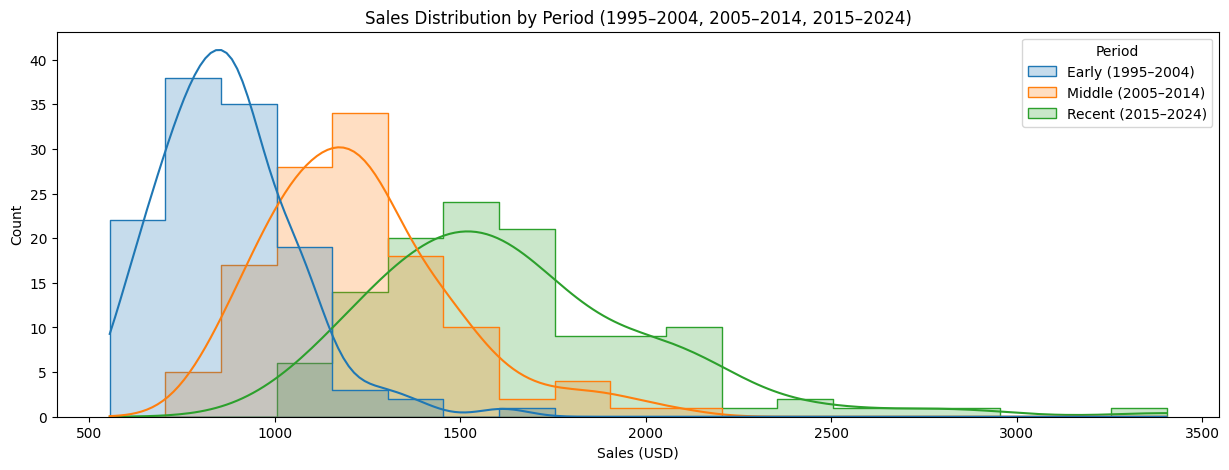

In [35]:
# Histogram of Sales by Period
plt.figure(figsize=(15, 5))
sns.histplot(data=merged_df, x='New_Sales', hue='Period', kde=True, element='step')
plt.title('Sales Distribution by Period (1995–2004, 2005–2014, 2015–2024)')
plt.xlabel('Sales (USD)')
plt.ylabel('Count')
plt.show()

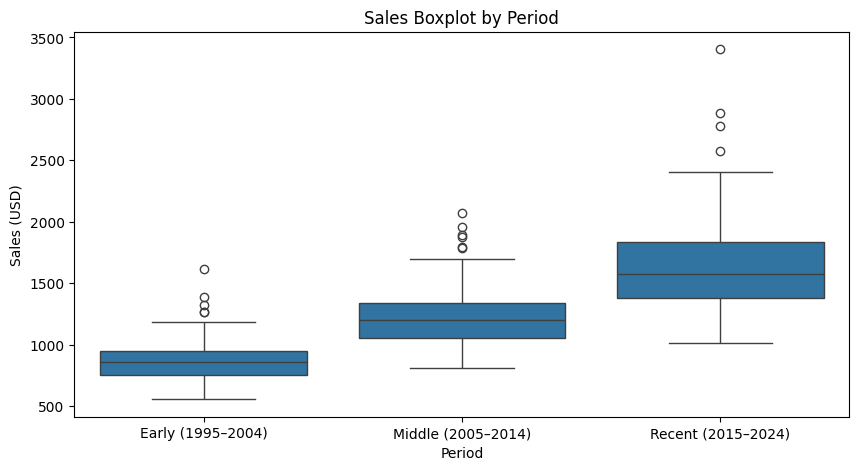

In [36]:
# Boxplot of Sales by Period
plt.figure(figsize=(10, 5))
sns.boxplot(x='Period', y='New_Sales', data=merged_df)
plt.title('Sales Boxplot by Period')
plt.xlabel('Period')
plt.ylabel('Sales (USD)')
plt.show()

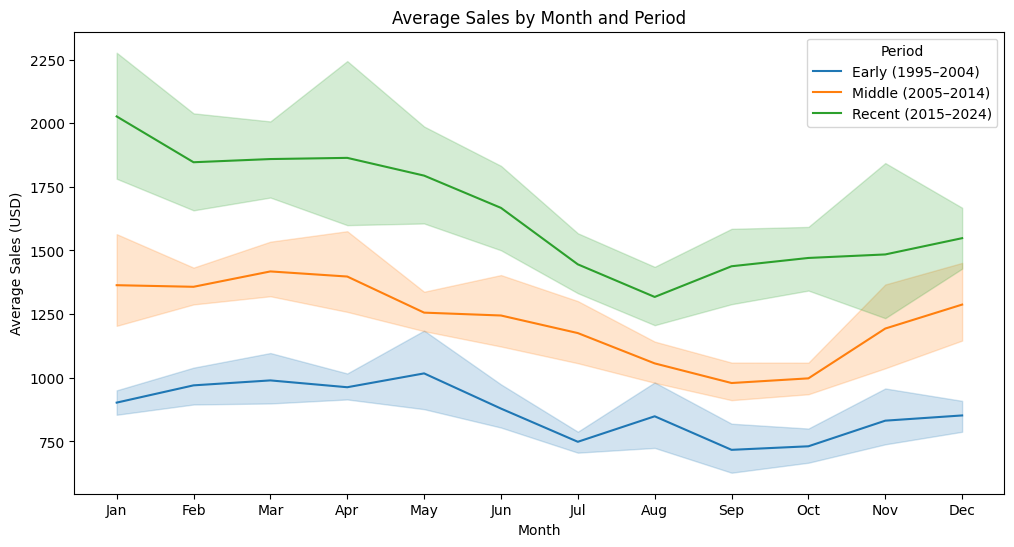

In [37]:
# Seasonal pattern comparison
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month_Name', y='New_Sales', hue='Period', data=merged_df, estimator='mean')
plt.title('Average Sales by Month and Period')
plt.xlabel('Month')
plt.ylabel('Average Sales (USD)')
plt.show()

In [38]:
# Promotion frequency
promo_freq = merged_df.groupby('Period')['Is_Promotion'].mean() * 12  # Average promotions per year
print("\nAverage Promotions per Year by Period:\n", promo_freq)


Average Promotions per Year by Period:
 Period
Early (1995–2004)     1.7
Middle (2005–2014)    1.7
Recent (2015–2024)    2.0
Name: Is_Promotion, dtype: float64


In [39]:
# Promotion types distribution
promo_type_dist = merged_df.groupby(['Period', 'Promo_Type']).size().unstack().fillna(0)
promo_type_dist = promo_type_dist.div(promo_type_dist.sum(axis=1), axis=0) * 100
print("\nPromotion Type Distribution (%):\n", promo_type_dist)


Promotion Type Distribution (%):
 Promo_Type            Bundle  Cashback  Discount  Non_Promo
Period                                                     
Early (1995–2004)   7.500000  0.833333  5.833333  85.833333
Middle (2005–2014)  6.666667  0.833333  6.666667  85.833333
Recent (2015–2024)  9.166667  0.833333  6.666667  83.333333


<Figure size 1200x600 with 0 Axes>

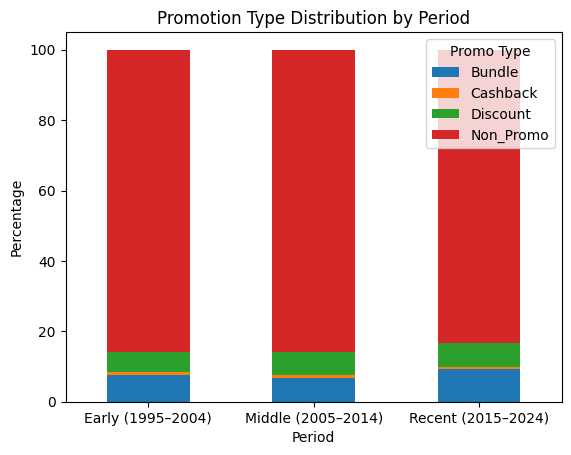

In [40]:
# Stacked Bar Plot of Promotion Types
plt.figure(figsize=(12, 6))
promo_type_dist.plot(kind='bar', stacked=True)
plt.title('Promotion Type Distribution by Period')
plt.xlabel('Period')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Promo Type')
plt.show()

In [41]:
# Budget comparison (when Budget > 0)
budget_stats = merged_df[merged_df['Budget_USD'] > 0].groupby('Period')['Budget_USD'].describe()
print("\nBudget Statistics by Period (where Budget > 0):\n", budget_stats)


Budget Statistics by Period (where Budget > 0):
                     count          mean          std     min      25%  \
Period                                                                  
Early (1995–2004)    17.0  13117.647059  6203.651676  5000.0   7000.0   
Middle (2005–2014)   17.0  15411.764706  5756.070964  6000.0  11000.0   
Recent (2015–2024)   20.0  14800.000000  6126.731764  6000.0  10250.0   

                        50%      75%      max  
Period                                         
Early (1995–2004)   11000.0  19000.0  22000.0  
Middle (2005–2014)  16000.0  21000.0  24000.0  
Recent (2015–2024)  17000.0  19250.0  23000.0  


In [42]:
# Promotion impact
promo_impact = merged_df.groupby(['Period', 'Is_Promotion'])['New_Sales'].mean().unstack()
promo_impact['Impact'] = promo_impact[1] - promo_impact[0]
print("\nPromotion Impact by Period (Sales with Promo - Sales without Promo):\n", promo_impact)


Promotion Impact by Period (Sales with Promo - Sales without Promo):
 Is_Promotion                  0            1      Impact
Period                                                  
Early (1995–2004)    828.531524  1127.280523  298.748999
Middle (2005–2014)  1159.809344  1635.930491  476.121147
Recent (2015–2024)  1546.768143  2147.113121  600.344978


In [43]:
# Promotion type impact
promo_type_impact = merged_df.groupby(['Period', 'Promo_Type'])['New_Sales'].mean().unstack()
print("\nAverage Sales by Promotion Type and Period:\n", promo_type_impact)


Average Sales by Promotion Type and Period:
 Promo_Type               Bundle     Cashback     Discount    Non_Promo
Period                                                                
Early (1995–2004)   1071.138952  1325.174995  1171.191904   828.531524
Middle (2005–2014)  1614.740710  1598.479152  1661.801690  1159.809344
Recent (2015–2024)  2078.164323  3404.428595  2084.753284  1546.768143



Budget Statistics (2015–2024, Budget > 0):
count       20.000000
mean     14800.000000
std       6126.731764
min       6000.000000
25%      10250.000000
50%      17000.000000
75%      19250.000000
max      23000.000000
Name: Budget_USD, dtype: float64


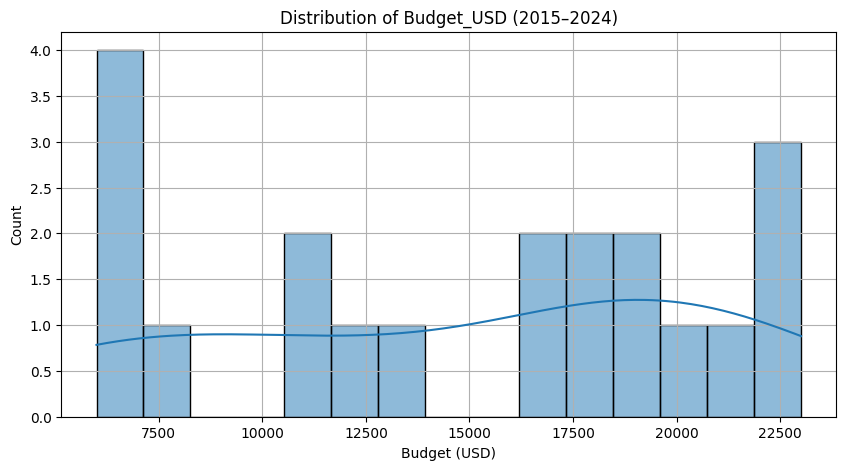

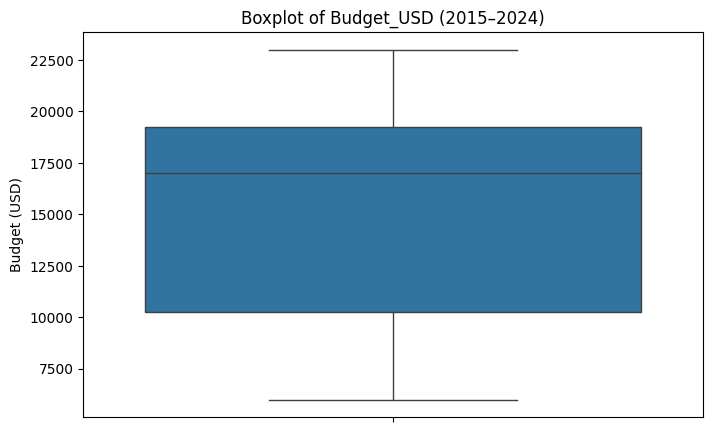


Budget Statistics by Promo_Type (2015–2024):
            count          mean          std      min      25%      50%  \
Promo_Type                                                                
Bundle       11.0  14545.454545  6713.622515   6000.0   8500.0  17000.0   
Cashback      1.0  19000.000000          NaN  19000.0  19000.0  19000.0   
Discount      8.0  14625.000000  5902.481318   6000.0  11000.0  15000.0   

                75%      max  
Promo_Type                    
Bundle      20000.0  23000.0  
Cashback    19000.0  19000.0  
Discount    18500.0  23000.0  


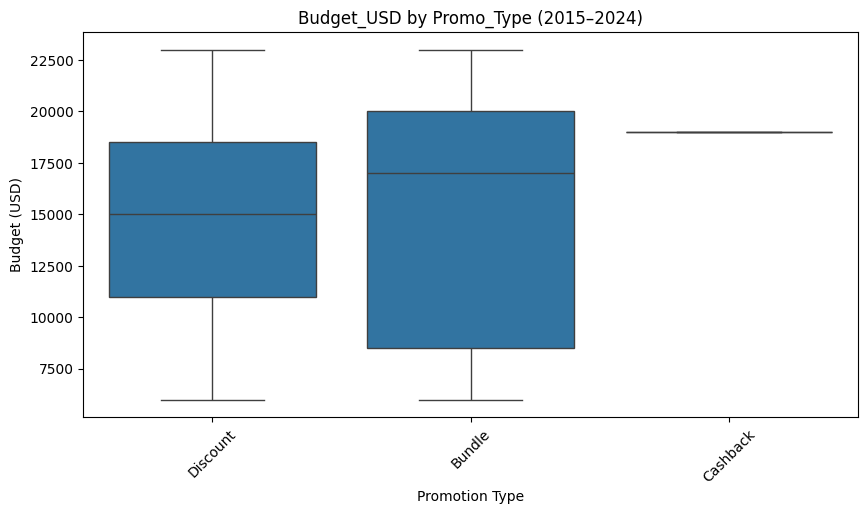


Average Budget by Month (2015–2024):
 Month_Name
Jan    18000.00
Feb    12000.00
Mar     6000.00
Apr    19000.00
May    21500.00
Jun     9000.00
Jul         NaN
Aug     6000.00
Sep    10500.00
Oct    15333.33
Nov    23000.00
Dec         NaN
Name: Budget_USD, dtype: float64


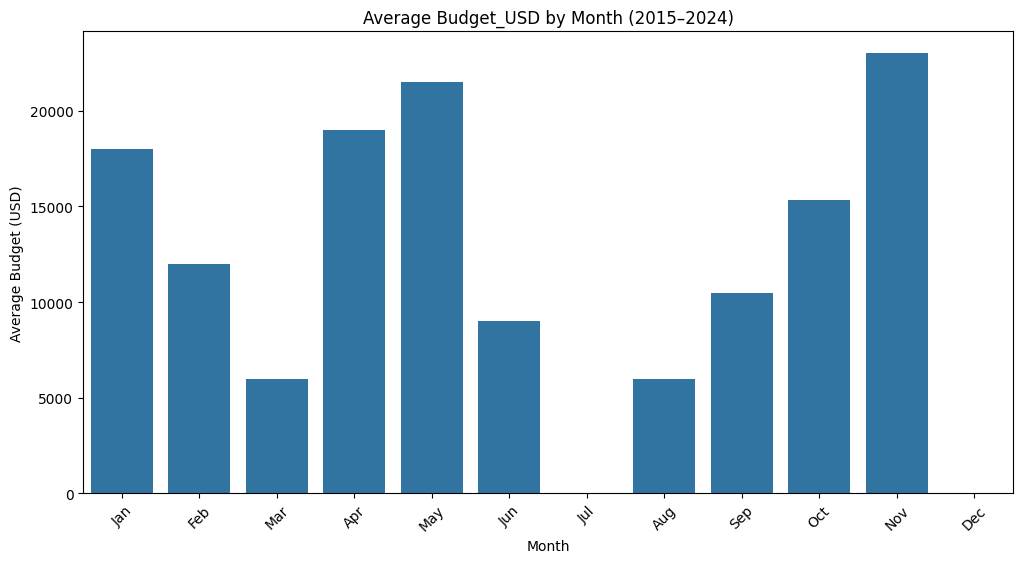


Correlation Matrix (2015–2024, Budget > 0):
               Budget_USD  New_Sales  Is_Promotion
Budget_USD         1.000      0.521           NaN
New_Sales          0.521      1.000           NaN
Is_Promotion         NaN        NaN           NaN


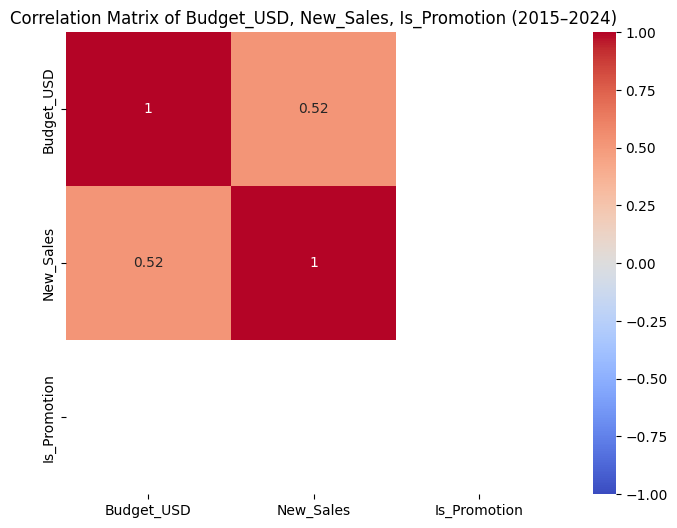


Monthly Budget Distribution (01/2015–12/2024):
        Date Promo_Type  Budget_USD
0    2015-01   Discount     20000.0
1    2015-02     Bundle     18000.0
2    2015-03     Bundle      6000.0
3    2015-04  Non_Promo         0.0
4    2015-05  Non_Promo         0.0
..       ...        ...         ...
115  2024-08  Non_Promo         0.0
116  2024-09  Non_Promo         0.0
117  2024-10  Non_Promo         0.0
118  2024-11   Discount     23000.0
119  2024-12  Non_Promo         0.0

[120 rows x 3 columns]


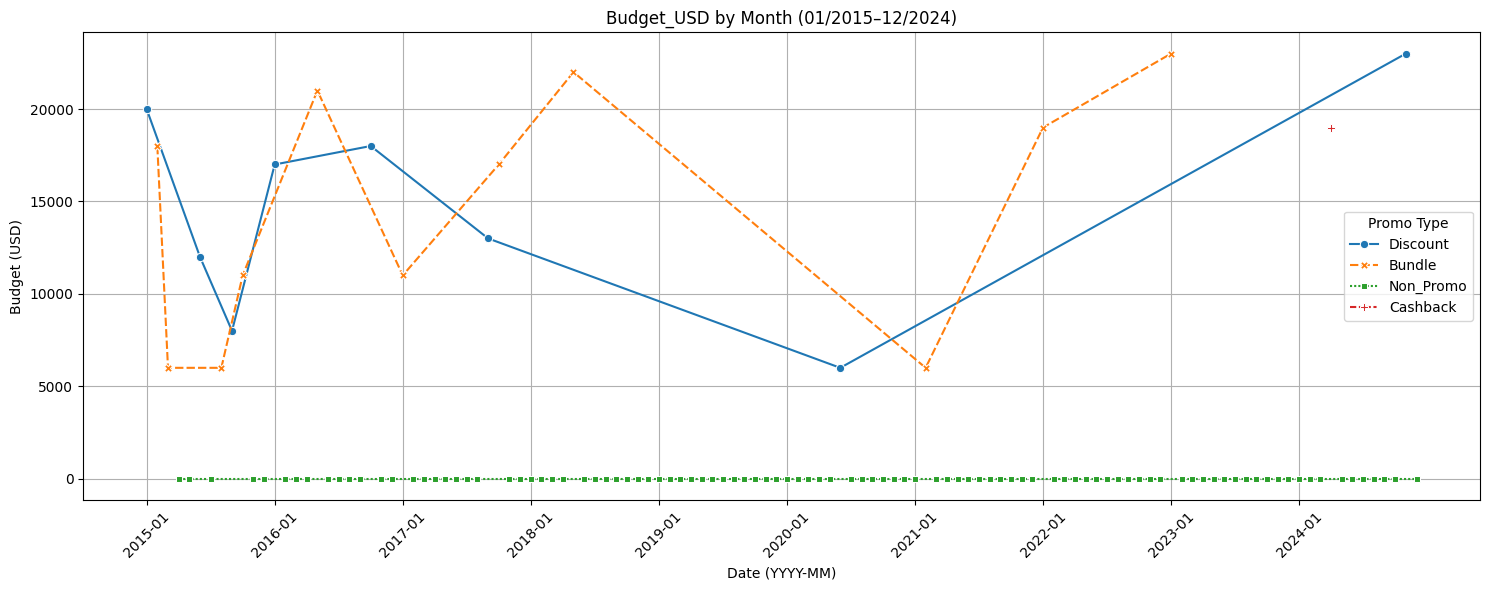

<Figure size 1500x600 with 0 Axes>

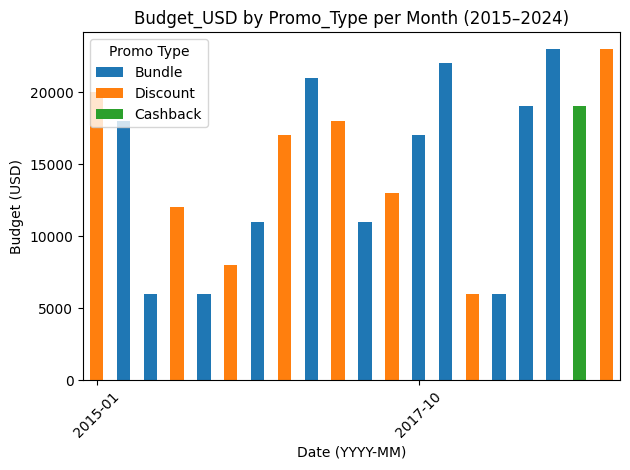

In [44]:
# --- Budget Analysis for Last 10 Years (2015–12/2024) with Monthly Distribution ---
# Filter data for 2015–2024
budget_full = merged_df[(merged_df['Year'] >= 2015) & (merged_df['Year'] <= 2024)]
budget_recent = budget_full[budget_full['Budget_USD'] > 0]

# Descriptive statistics for Budget_USD (when Budget > 0)
print("\nBudget Statistics (2015–2024, Budget > 0):")
print(budget_recent['Budget_USD'].describe())

# Histogram and KDE for Budget_USD
plt.figure(figsize=(10, 5))
sns.histplot(budget_recent['Budget_USD'], kde=True, bins=15)
plt.title('Distribution of Budget_USD (2015–2024)')
plt.xlabel('Budget (USD)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Boxplot for Budget_USD
plt.figure(figsize=(8, 5))
sns.boxplot(y=budget_recent['Budget_USD'])
plt.title('Boxplot of Budget_USD (2015–2024)')
plt.ylabel('Budget (USD)')
plt.show()

# Budget by Promo_Type
print("\nBudget Statistics by Promo_Type (2015–2024):")
print(budget_recent.groupby('Promo_Type')['Budget_USD'].describe())

# Boxplot for Budget_USD by Promo_Type
plt.figure(figsize=(10, 5))
sns.boxplot(x='Promo_Type', y='Budget_USD', data=budget_recent)
plt.title('Budget_USD by Promo_Type (2015–2024)')
plt.xlabel('Promotion Type')
plt.ylabel('Budget (USD)')
plt.xticks(rotation=45)
plt.show()

# Budget by Month (average across years)
budget_by_month = budget_recent.groupby('Month_Name')['Budget_USD'].mean().reindex(
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
print("\nAverage Budget by Month (2015–2024):\n", budget_by_month.round(2))

# Bar Plot for Average Budget by Month
plt.figure(figsize=(12, 6))
sns.barplot(x=budget_by_month.index, y=budget_by_month.values)
plt.title('Average Budget_USD by Month (2015–2024)')
plt.xlabel('Month')
plt.ylabel('Average Budget (USD)')
plt.xticks(rotation=45)
plt.show()

# Correlation Analysis
corr_cols = ['Budget_USD', 'New_Sales', 'Is_Promotion']
correlation_matrix = budget_recent[corr_cols].corr()
print("\nCorrelation Matrix (2015–2024, Budget > 0):\n", correlation_matrix.round(3))

# Heatmap for Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Budget_USD, New_Sales, Is_Promotion (2015–2024)')
plt.show()

# Monthly Budget Distribution (01/2015–12/2024)
print("\nMonthly Budget Distribution (01/2015–12/2024):")
monthly_budget = budget_full[['Budget_USD', 'Promo_Type']].reset_index()
monthly_budget = monthly_budget[['Date', 'Promo_Type', 'Budget_USD']]
monthly_budget['Date'] = monthly_budget['Date'].dt.strftime('%Y-%m')
print(monthly_budget)

# Line Plot for Budget_USD over time
plt.figure(figsize=(15, 6))
sns.lineplot(x='Date', y='Budget_USD', hue='Promo_Type', style='Promo_Type', markers=True, data=monthly_budget)
plt.title('Budget_USD by Month (01/2015–12/2024)')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Budget (USD)')
plt.xticks(ticks=range(0, len(monthly_budget), 12), labels=monthly_budget['Date'][::12], rotation=45)
plt.grid(True)
plt.legend(title='Promo Type')
plt.tight_layout()
plt.show()

# Stacked Bar Plot for Budget_USD by Promo_Type per Month
budget_pivot = budget_recent.pivot_table(values='Budget_USD', index=budget_recent.index.strftime('%Y-%m'),
                                         columns='Promo_Type', aggfunc='sum', fill_value=0)
budget_pivot = budget_pivot[['Bundle', 'Discount', 'Cashback']]  # Exclude Non_Promo
plt.figure(figsize=(15, 6))
budget_pivot.plot(kind='bar', stacked=True)
plt.title('Budget_USD by Promo_Type per Month (2015–2024)')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Budget (USD)')
plt.xticks(ticks=range(0, len(budget_pivot), 12), labels=budget_pivot.index[::12], rotation=45)
plt.legend(title='Promo Type')
plt.tight_layout()
plt.show()

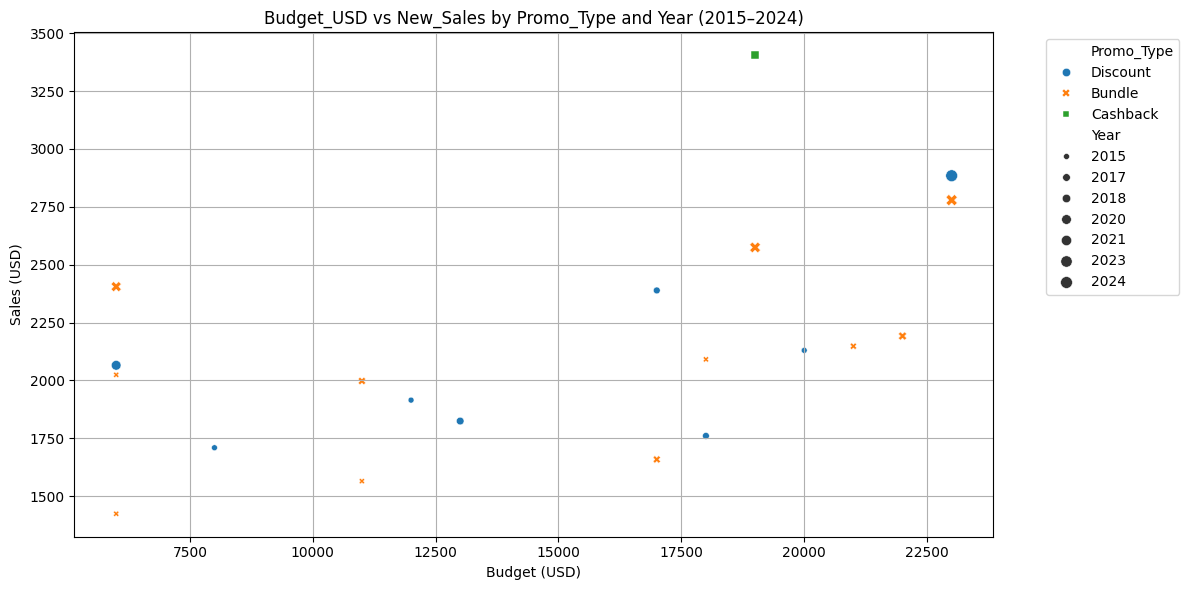

In [45]:
# --- Additional Budget Visualizations for Last 10 Years (2015–2024) ---
# Filter data for 2015–2024 with Budget_USD > 0
budget_recent = merged_df[(merged_df['Year'] >= 2015) & (merged_df['Year'] <= 2024) & (merged_df['Budget_USD'] > 0)]

# 1. Scatter Plot: Budget_USD vs New_Sales by Promo_Type and Year
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Budget_USD', y='New_Sales', hue='Promo_Type', size='Year', style='Promo_Type', data=budget_recent)
plt.title('Budget_USD vs New_Sales by Promo_Type and Year (2015–2024)')
plt.xlabel('Budget (USD)')
plt.ylabel('Sales (USD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

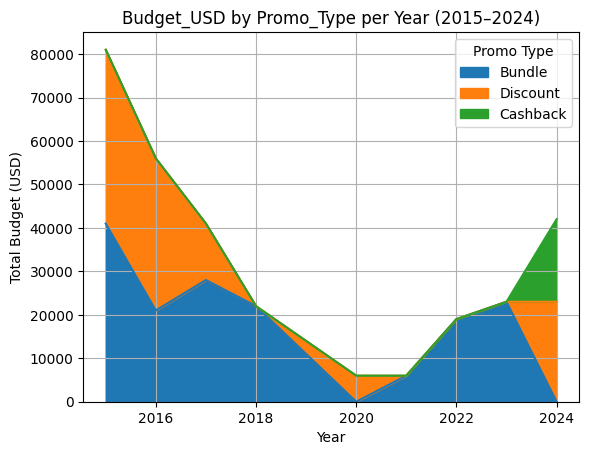

In [46]:
# 2. Stacked Area Plot: Budget_USD by Promo_Type per Year
budget_by_year = budget_recent.pivot_table(values='Budget_USD', index='Year', columns='Promo_Type', aggfunc='sum', fill_value=0)
budget_by_year = budget_by_year[['Bundle', 'Discount', 'Cashback']]  # Exclude Non_Promo
plt.figure(figsize=(12, 6))
budget_by_year.plot(kind='area', stacked=True)
plt.title('Budget_USD by Promo_Type per Year (2015–2024)')
plt.xlabel('Year')
plt.ylabel('Total Budget (USD)')
plt.legend(title='Promo Type')
plt.grid(True)
plt.show()

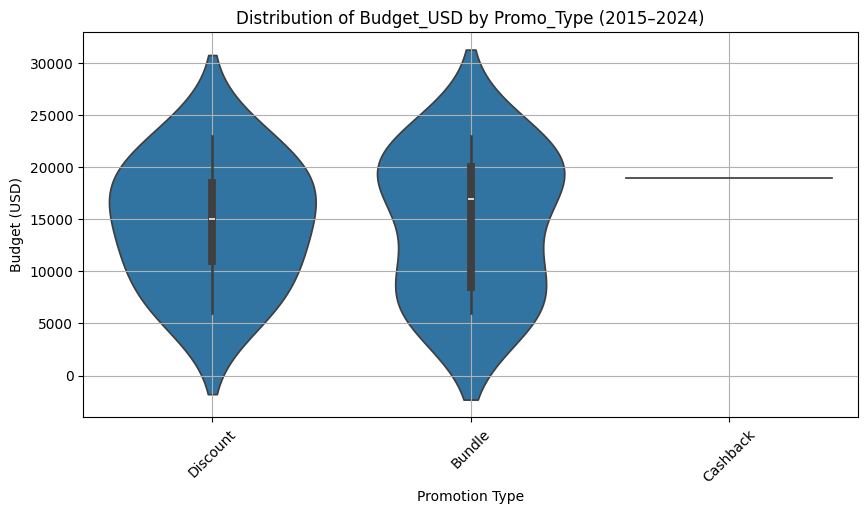

In [47]:
# 3. Violin Plot: Budget_USD by Promo_Type
plt.figure(figsize=(10, 5))
sns.violinplot(x='Promo_Type', y='Budget_USD', data=budget_recent)
plt.title('Distribution of Budget_USD by Promo_Type (2015–2024)')
plt.xlabel('Promotion Type')
plt.ylabel('Budget (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Efficiency (New_Sales/Budget_USD) by Promo_Type (2015–2024):
 Promo_Type
Bundle      0.179
Cashback    0.179
Discount    0.166
Name: Sales_per_Budget, dtype: float64


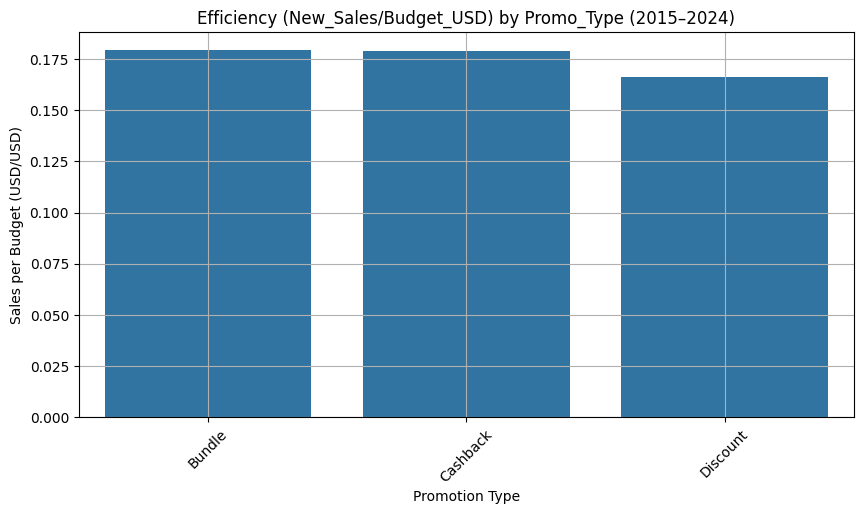

In [48]:
# 4. Bar Plot: Efficiency (New_Sales/Budget_USD) by Promo_Type
budget_recent['Sales_per_Budget'] = budget_recent['New_Sales'] / budget_recent['Budget_USD']
efficiency = budget_recent.groupby('Promo_Type')['Sales_per_Budget'].mean()
print("\nEfficiency (New_Sales/Budget_USD) by Promo_Type (2015–2024):\n", efficiency.round(3))
plt.figure(figsize=(10, 5))
sns.barplot(x=efficiency.index, y=efficiency.values)
plt.title('Efficiency (New_Sales/Budget_USD) by Promo_Type (2015–2024)')
plt.xlabel('Promotion Type')
plt.ylabel('Sales per Budget (USD/USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Frequency of Promo_Type by Month (2015–2024):
 Promo_Type  Bundle  Cashback  Discount  Non_Promo
Month_Name                                       
Jan            3.0       0.0       2.0        5.0
Feb            2.0       0.0       0.0        8.0
Mar            1.0       0.0       0.0        9.0
Apr            0.0       1.0       0.0        9.0
May            2.0       0.0       0.0        8.0
Jun            0.0       0.0       2.0        8.0
Jul            0.0       0.0       0.0       10.0
Aug            1.0       0.0       0.0        9.0
Sep            0.0       0.0       2.0        8.0
Oct            2.0       0.0       1.0        7.0
Nov            0.0       0.0       1.0        9.0
Dec            0.0       0.0       0.0       10.0


<Figure size 1200x600 with 0 Axes>

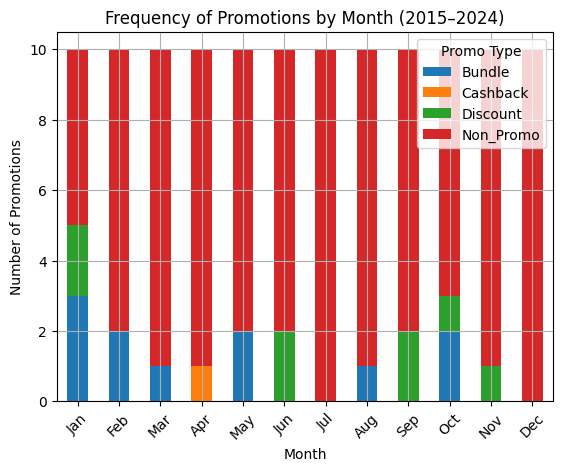


Percentage of Promo_Type by Month (2015–2024):
 Promo_Type  Bundle  Cashback  Discount  Non_Promo
Month_Name                                       
Jan           30.0       0.0      20.0       50.0
Feb           20.0       0.0       0.0       80.0
Mar           10.0       0.0       0.0       90.0
Apr            0.0      10.0       0.0       90.0
May           20.0       0.0       0.0       80.0
Jun            0.0       0.0      20.0       80.0
Jul            0.0       0.0       0.0      100.0
Aug           10.0       0.0       0.0       90.0
Sep            0.0       0.0      20.0       80.0
Oct           20.0       0.0      10.0       70.0
Nov            0.0       0.0      10.0       90.0
Dec            0.0       0.0       0.0      100.0


<Figure size 1200x600 with 0 Axes>

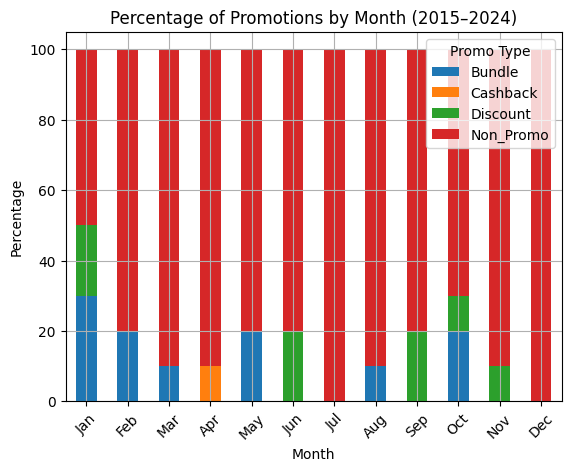


Frequency of Active Promotions by Month (2015–2024, excluding Non_Promo):
 Promo_Type  Bundle  Cashback  Discount
Month_Name                            
Jan            3.0       0.0       2.0
Feb            2.0       0.0       0.0
Mar            1.0       0.0       0.0
Apr            0.0       1.0       0.0
May            2.0       0.0       0.0
Jun            0.0       0.0       2.0
Jul            NaN       NaN       NaN
Aug            1.0       0.0       0.0
Sep            0.0       0.0       2.0
Oct            2.0       0.0       1.0
Nov            0.0       0.0       1.0
Dec            NaN       NaN       NaN


<Figure size 1200x600 with 0 Axes>

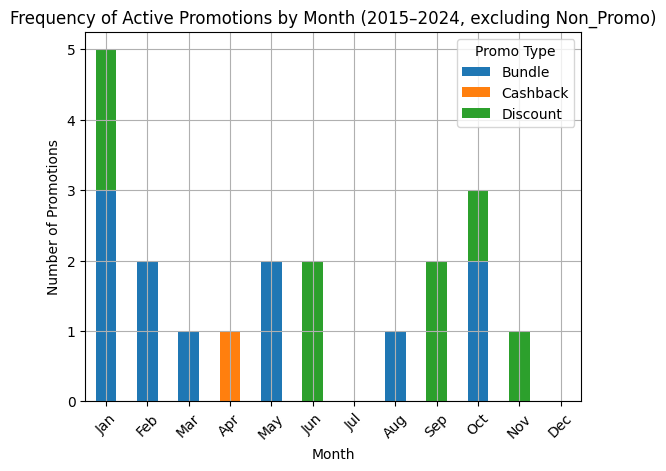

In [49]:
# --- Frequency Analysis of Promotions by Month (2015–2024) ---

# Lọc dữ liệu từ 2015 đến 2024
df_filtered = merged_df[(merged_df['Year'] >= 2015) & (merged_df['Year'] <= 2024)]

# 1. Tần suất khuyến mãi theo tháng
# Đếm số lần xuất hiện của từng Promo_Type theo Month_Name
promo_freq_by_month = df_filtered.groupby(['Month_Name', 'Promo_Type']).size().unstack().fillna(0)
promo_freq_by_month = promo_freq_by_month.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
print("\nFrequency of Promo_Type by Month (2015–2024):\n", promo_freq_by_month)

# Bar Plot: Tần suất khuyến mãi theo tháng
plt.figure(figsize=(12, 6))
promo_freq_by_month.plot(kind='bar', stacked=True)
plt.title('Frequency of Promotions by Month (2015–2024)')
plt.xlabel('Month')
plt.ylabel('Number of Promotions')
plt.xticks(rotation=45)
plt.legend(title='Promo Type')
plt.grid(True)
plt.show()

# 2. Tỷ lệ phần trăm khuyến mãi theo tháng
promo_percent_by_month = promo_freq_by_month.div(promo_freq_by_month.sum(axis=1), axis=0) * 100
print("\nPercentage of Promo_Type by Month (2015–2024):\n", promo_percent_by_month)

# Stacked Bar Plot: Tỷ lệ phần trăm khuyến mãi theo tháng
plt.figure(figsize=(12, 6))
promo_percent_by_month.plot(kind='bar', stacked=True)
plt.title('Percentage of Promotions by Month (2015–2024)')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Promo Type')
plt.grid(True)
plt.show()

# 3. Tần suất khuyến mãi cụ thể (chỉ xét các tháng có khuyến mãi, không tính Non_Promo)
promo_active = df_filtered[df_filtered['Promo_Type'] != 'Non_Promo']
promo_active_freq = promo_active.groupby(['Month_Name', 'Promo_Type']).size().unstack().fillna(0)
promo_active_freq = promo_active_freq.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
print("\nFrequency of Active Promotions by Month (2015–2024, excluding Non_Promo):\n", promo_active_freq)

# Bar Plot: Tần suất các khuyến mãi cụ thể theo tháng
plt.figure(figsize=(12, 6))
promo_active_freq.plot(kind='bar', stacked=True)
plt.title('Frequency of Active Promotions by Month (2015–2024, excluding Non_Promo)')
plt.xlabel('Month')
plt.ylabel('Number of Promotions')
plt.xticks(rotation=45)
plt.legend(title='Promo Type')
plt.grid(True)
plt.show()

**TỪ ĐOẠN NÀY T LÀM THÊM XEM CÓ GÌ KHÔNG NHÉ**

In [53]:
# --- Frequency Analysis of Promotions by Period and Season with Line Plots (1995–2024) ---

# Lọc dữ liệu từ 1995 đến 2024
df_filtered = merged_df[(merged_df['Year'] >= 1995) & (merged_df['Year'] <= 2024)]

# Định nghĩa mùa dựa trên Month_Name
season_mapping = {
    'Jan': 'Winter', 'Feb': 'Winter', 'Mar': 'Spring', 'Apr': 'Spring', 'May': 'Spring',
    'Jun': 'Summer', 'Jul': 'Summer', 'Aug': 'Summer', 'Sep': 'Fall', 'Oct': 'Fall',
    'Nov': 'Fall', 'Dec': 'Winter'
}
df_filtered['Season'] = df_filtered['Month_Name'].map(season_mapping)

# 1. Phân tích tần suất khuyến mãi theo giai đoạn

# --- 5-year periods (1995–1999, 2000–2004, ..., 2020–2024) ---
df_filtered['Period_5yr'] = pd.cut(df_filtered['Year'],
                                   bins=[1994, 1999, 2004, 2009, 2014, 2019, 2024],
                                   labels=['1995–1999', '2000–2004', '2005–2009', '2010–2014', '2015–2019', '2020–2024'],
                                   include_lowest=True)

# Tần suất khuyến mãi theo tháng và Promo_Type trong từng giai đoạn 5 năm
freq_5yr = df_filtered.groupby(['Period_5yr', 'Month_Name', 'Promo_Type']).size().unstack().fillna(0)
freq_5yr = freq_5yr.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], level=1)
print("\nFrequency of Promotions by 5-Year Period and Month (1995–2024):\n", freq_5yr)

# Line Plot: Tần suất khuyến mãi theo tháng, phân tách theo giai đoạn 5 năm
for promo_type in freq_5yr.columns:
    plt.figure(figsize=(12, 6))
    for period in freq_5yr.index.get_level_values('Period_5yr').unique():
        plt.plot(freq_5yr.loc[period].index, freq_5yr.loc[period][promo_type], marker='o', label=period)
    plt.title(f'Trend of {promo_type} Promotions by Month (5-Year Periods, 1995–2024)')
    plt.xlabel('Month')
    plt.ylabel('Number of Promotions')
    plt.xticks(rotation=45)
    plt.legend(title='Period')
    plt.grid(True)
    plt.show()

# --- 3-year periods (1995–1997, 1998–2000, ..., 2021–2023, 2024) ---
df_filtered['Period_3yr'] = pd.cut(df_filtered['Year'],
                                   bins=[1994, 1997, 2000, 2003, 2006, 2009, 2012, 2015, 2018, 2021, 2023, 2024],
                                   labels=['1995–1997', '1998–2000', '2001–2003', '2004–2006', '2007–2009',
                                           '2010–2012', '2013–2015', '2016–2018', '2019–2021', '2022–2023', '2024'],
                                   include_lowest=True)

# Tần suất khuyến mãi theo tháng và Promo_Type trong từng giai đoạn 3 năm
freq_3yr = df_filtered.groupby(['Period_3yr', 'Month_Name', 'Promo_Type']).size().unstack().fillna(0)
freq_3yr = freq_3yr.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], level=1)
print("\nFrequency of Promotions by 3-Year Period and Month (1995–2024):\n", freq_3yr)

# Line Plot: Tần suất khuyến mãi theo tháng, phân tách theo giai đoạn 3 năm
for promo_type in freq_3yr.columns:
    plt.figure(figsize=(12, 6))
    for period in freq_3yr.index.get_level_values('Period_3yr').unique():
        plt.plot(freq_3yr.loc[period].index, freq_3yr.loc[period][promo_type], marker='o', label=period)
    plt.title(f'Trend of {promo_type} Promotions by Month (3-Year Periods, 1995–2024)')
    plt.xlabel('Month')
    plt.ylabel('Number of Promotions')
    plt.xticks(rotation=45)
    plt.legend(title='Period')
    plt.grid(True)
    plt.show()

# --- 2-year periods (1995–1996, 1997–1998, ..., 2023–2024) ---
df_filtered['Period_2yr'] = pd.cut(df_filtered['Year'],
                                   bins=[1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014,
                                         2016, 2018, 2020, 2022, 2024],
                                   labels=['1995–1996', '1997–1998', '1999–2000', '2001–2002', '2003–2004',
                                           '2005–2006', '2007–2008', '2009–2010', '2011–2012', '2013–2014',
                                           '2015–2016', '2017–2018', '2019–2020', '2021–2022', '2023–2024'],
                                   include_lowest=True)

# Tần suất khuyến mãi theo tháng và Promo_Type trong từng giai đoạn 2 năm
freq_2yr = df_filtered.groupby(['Period_2yr', 'Month_Name', 'Promo_Type']).size().unstack().fillna(0)
freq_2yr = freq_2yr.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], level=1)
print("\nFrequency of Promotions by 2-Year Period and Month (1995–2024):\n", freq_2yr)

# Line Plot: Tần suất khuyến mãi theo tháng, phân tách theo giai đoạn 2 năm
for promo_type in freq_2yr.columns:
    plt.figure(figsize=(12, 6))
    for period in freq_2yr.index.get_level_values('Period_2yr').unique():
        plt.plot(freq_2yr.loc[period].index, freq_2yr.loc[period][promo_type], marker='o', label=period)
    plt.title(f'Trend of {promo_type} Promotions by Month (2-Year Periods, 1995–2024)')
    plt.xlabel('Month')
    plt.ylabel('Number of Promotions')
    plt.xticks(rotation=45)
    plt.legend(title='Period')
    plt.grid(True)
    plt.show()

# 2. Phân tích tần suất trung bình theo mùa trong từng giai đoạn

# --- 5-year periods: Seasonal Average ---
promo_active = df_filtered[df_filtered['Promo_Type'] != 'Non_Promo']
seasonal_avg_5yr = promo_active.groupby(['Period_5yr', 'Season'])['Promo_Type'].count().unstack().fillna(0)
# Chia cho số năm trong mỗi giai đoạn (5 năm) để tính trung bình
seasonal_avg_5yr = seasonal_avg_5yr / 5
seasonal_avg_5yr = seasonal_avg_5yr.reindex(columns=['Winter', 'Spring', 'Summer', 'Fall'])
print("\nAverage Number of Promotions per Season (5-Year Periods, 1995–2024):\n", seasonal_avg_5yr)

# Line Plot: Tần suất trung bình theo mùa, phân tách theo giai đoạn 5 năm
plt.figure(figsize=(12, 6))
for period in seasonal_avg_5yr.index:
    plt.plot(seasonal_avg_5yr.columns, seasonal_avg_5yr.loc[period], marker='o', label=period)
plt.title('Trend of Average Promotions per Season (5-Year Periods, 1995–2024)')
plt.xlabel('Season')
plt.ylabel('Average Number of Promotions per Season')
plt.legend(title='Period')
plt.grid(True)
plt.show()

# --- 3-year periods: Seasonal Average ---
seasonal_avg_3yr = promo_active.groupby(['Period_3yr', 'Season'])['Promo_Type'].count().unstack().fillna(0)
# Chia cho số năm trong mỗi giai đoạn (3 năm, riêng 2024 là 1 năm)
seasonal_avg_3yr.loc['1995–1997'] = seasonal_avg_3yr.loc['1995–1997'] / 3
seasonal_avg_3yr.loc['1998–2000'] = seasonal_avg_3yr.loc['1998–2000'] / 3
seasonal_avg_3yr.loc['2001–2003'] = seasonal_avg_3yr.loc['2001–2003'] / 3
seasonal_avg_3yr.loc['2004–2006'] = seasonal_avg_3yr.loc['2004–2006'] / 3
seasonal_avg_3yr.loc['2007–2009'] = seasonal_avg_3yr.loc['2007–2009'] / 3
seasonal_avg_3yr.loc['2010–2012'] = seasonal_avg_3yr.loc['2010–2012'] / 3
seasonal_avg_3yr.loc['2013–2015'] = seasonal_avg_3yr.loc['2013–2015'] / 3
seasonal_avg_3yr.loc['2016–2018'] = seasonal_avg_3yr.loc['2016–2018'] / 3
seasonal_avg_3yr.loc['2019–2021'] = seasonal_avg_3yr.loc['2019–2021'] / 3
seasonal_avg_3yr.loc['2022–2023'] = seasonal_avg_3yr.loc['2022–2023'] / 2
seasonal_avg_3yr.loc['2024'] = seasonal_avg_3yr.loc['2024'] / 1
seasonal_avg_3yr = seasonal_avg_3yr.reindex(columns=['Winter', 'Spring', 'Summer', 'Fall'])
print("\nAverage Number of Promotions per Season (3-Year Periods, 1995–2024):\n", seasonal_avg_3yr)

# Line Plot: Tần suất trung bình theo mùa, phân tách theo giai đoạn 3 năm
plt.figure(figsize=(12, 6))
for period in seasonal_avg_3yr.index:
    plt.plot(seasonal_avg_3yr.columns, seasonal_avg_3yr.loc[period], marker='o', label=period)
plt.title('Trend of Average Promotions per Season (3-Year Periods, 1995–2024)')
plt.xlabel('Season')
plt.ylabel('Average Number of Promotions per Season')
plt.legend(title='Period')
plt.grid(True)
plt.show()

# --- 2-year periods: Seasonal Average ---
seasonal_avg_2yr = promo_active.groupby(['Period_2yr', 'Season'])['Promo_Type'].count().unstack().fillna(0)
# Chia cho số năm trong mỗi giai đoạn (2 năm)
seasonal_avg_2yr = seasonal_avg_2yr / 2
seasonal_avg_2yr = seasonal_avg_2yr.reindex(columns=['Winter', 'Spring', 'Summer', 'Fall'])
print("\nAverage Number of Promotions per Season (2-Year Periods, 1995–2024):\n", seasonal_avg_2yr)

# Line Plot: Tần suất trung bình theo mùa, phân tách theo giai đoạn 2 năm
plt.figure(figsize=(12, 6))
for period in seasonal_avg_2yr.index:
    plt.plot(seasonal_avg_2yr.columns, seasonal_avg_2yr.loc[period], marker='o', label=period)
plt.title('Trend of Average Promotions per Season (2-Year Periods, 1995–2024)')
plt.xlabel('Season')
plt.ylabel('Average Number of Promotions per Season')
plt.legend(title='Period')
plt.grid(True)
plt.show()

Output hidden; open in https://colab.research.google.com to view.


Total Frequency of Promotions (Bundle, Discount, Cashback) by 5-Year Period (1995–2024):
 Promo_Type  Bundle  Cashback  Discount
Period_5yr                            
1995–1999        5         0         5
2000–2004        4         1         2
2005–2009        3         1         4
2010–2014        5         0         4
2015–2019        8         0         6
2020–2024        3         1         2


<Figure size 1200x600 with 0 Axes>

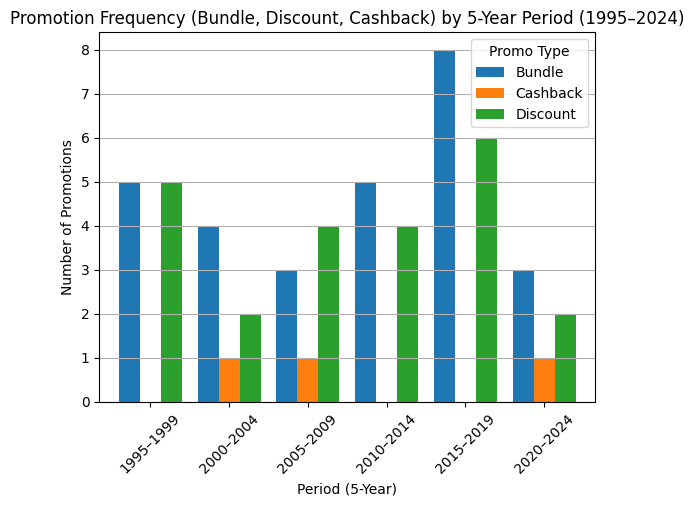


Total Frequency of Promotions (Bundle, Discount, Cashback) by 3-Year Period (1995–2024):
 Promo_Type  Bundle  Cashback  Discount
Period_3yr                            
1995–1997        3         0         2
1998–2000        3         0         3
2001–2003        2         1         0
2004–2006        3         1         4
2007–2009        1         0         2
2010–2012        3         0         4
2013–2015        6         0         3
2016–2018        4         0         3
2019–2021        1         0         1
2022–2023        2         0         0
2024             0         1         1


<Figure size 1200x600 with 0 Axes>

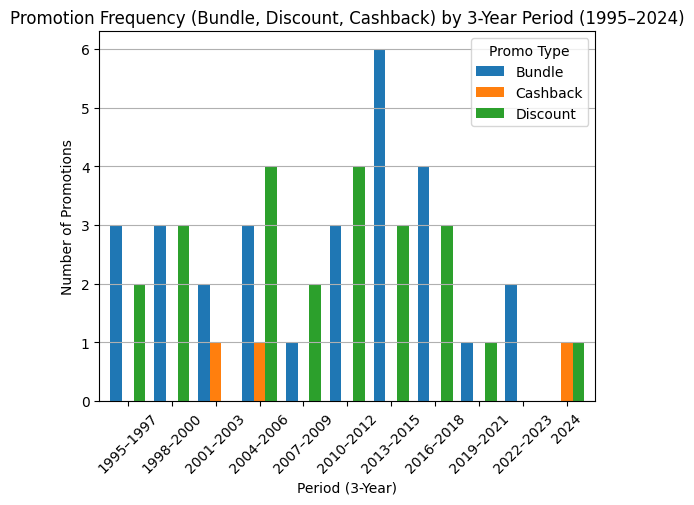


Total Frequency of Promotions (Bundle, Discount, Cashback) by 2-Year Period (1995–2024):
 Promo_Type  Bundle  Cashback  Discount
Period_2yr                            
1995–1996        2         0         1
1997–1998        1         0         2
1999–2000        3         0         2
2001–2002        1         1         0
2003–2004        2         0         2
2005–2006        2         1         2
2007–2008        1         0         1
2009–2010        1         0         3
2011–2012        2         0         2
2013–2014        2         0         0
2015–2016        5         0         5
2017–2018        3         0         1
2019–2020        0         0         1
2021–2022        2         0         0
2023–2024        1         1         1


<Figure size 1200x600 with 0 Axes>

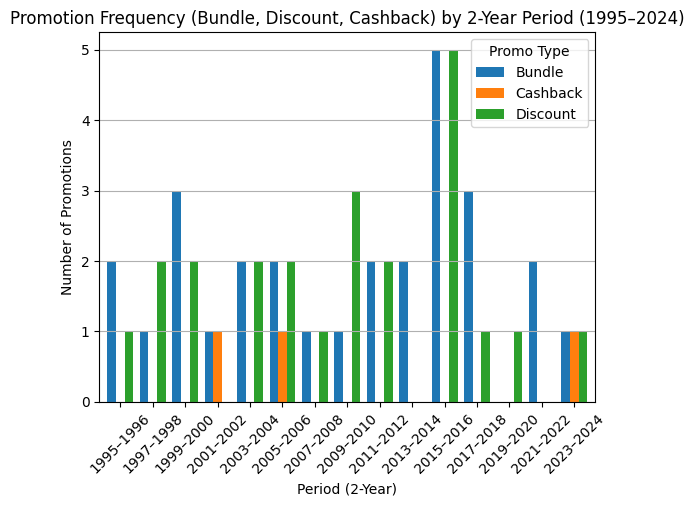


Average Number of Promotions per Season (Bundle, Discount, Cashback) (5-Year Periods, 1995–2024):
 Promo_Type  Season  Bundle  Cashback  Discount
Period_5yr                                    
1995–1999     Fall     0.2       0.0       0.2
1995–1999   Spring     0.4       0.0       0.0
1995–1999   Summer     0.2       0.0       0.6
1995–1999   Winter     0.2       0.0       0.2
2000–2004     Fall     0.8       0.0       0.0
2000–2004   Spring     0.0       0.2       0.2
2000–2004   Summer     0.0       0.0       0.2
2000–2004   Winter     0.0       0.0       0.0
2005–2009     Fall     0.2       0.0       0.4
2005–2009   Spring     0.0       0.2       0.0
2005–2009   Summer     0.2       0.0       0.4
2005–2009   Winter     0.2       0.0       0.0
2010–2014     Fall     0.2       0.0       0.0
2010–2014   Spring     0.2       0.0       0.2
2010–2014   Summer     0.2       0.0       0.2
2010–2014   Winter     0.4       0.0       0.4
2015–2019     Fall     0.4       0.0       0.6
2015–20

<Figure size 1200x600 with 0 Axes>

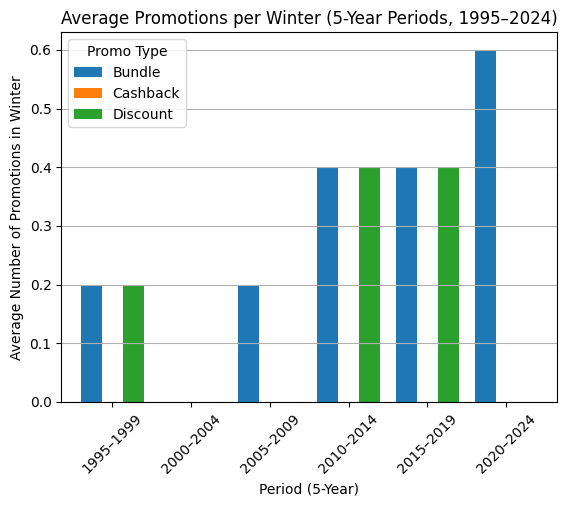

<Figure size 1200x600 with 0 Axes>

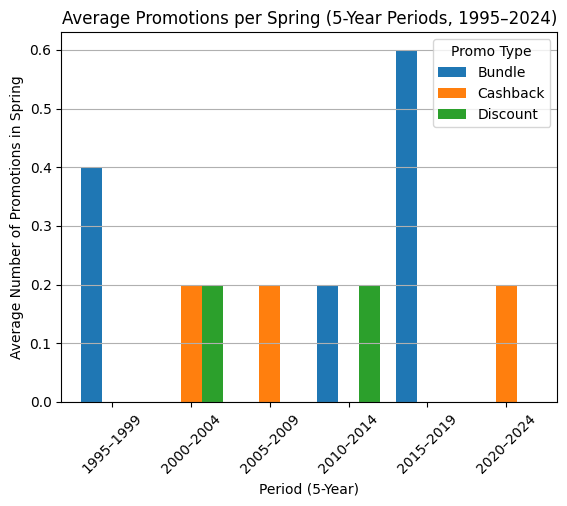

<Figure size 1200x600 with 0 Axes>

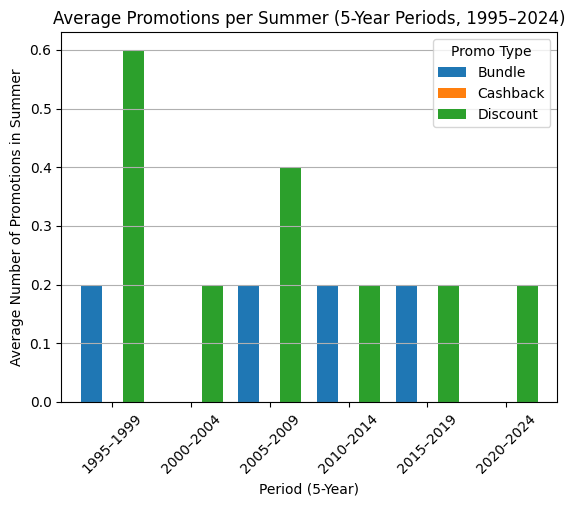

<Figure size 1200x600 with 0 Axes>

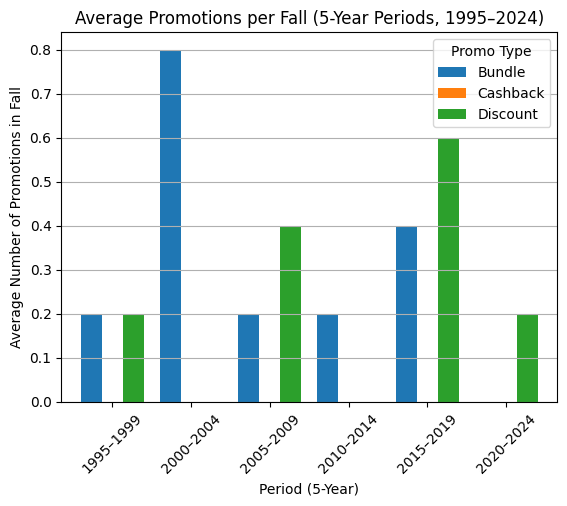


Average Number of Promotions per Season (Bundle, Discount, Cashback) (3-Year Periods, 1995–2024):
 Promo_Type  Season  Bundle  Cashback  Discount
Period_3yr                                    
1995–1997     Fall     NaN       NaN       NaN
1995–1997   Spring     NaN       NaN       NaN
1995–1997   Summer     NaN       NaN       NaN
1995–1997   Winter     NaN       NaN       NaN
1998–2000     Fall     NaN       NaN       NaN
1998–2000   Spring     NaN       NaN       NaN
1998–2000   Summer     NaN       NaN       NaN
1998–2000   Winter     NaN       NaN       NaN
2001–2003     Fall     NaN       NaN       NaN
2001–2003   Spring     NaN       NaN       NaN
2001–2003   Summer     NaN       NaN       NaN
2001–2003   Winter     NaN       NaN       NaN
2004–2006     Fall     NaN       NaN       NaN
2004–2006   Spring     NaN       NaN       NaN
2004–2006   Summer     NaN       NaN       NaN
2004–2006   Winter     NaN       NaN       NaN
2007–2009     Fall     NaN       NaN       NaN
2007–20

<Figure size 1200x600 with 0 Axes>

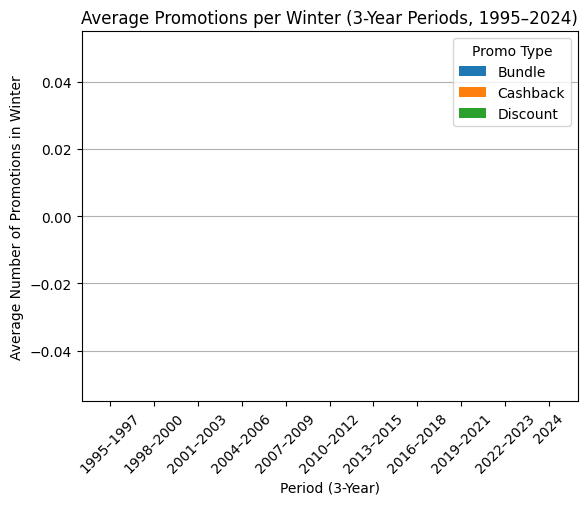

<Figure size 1200x600 with 0 Axes>

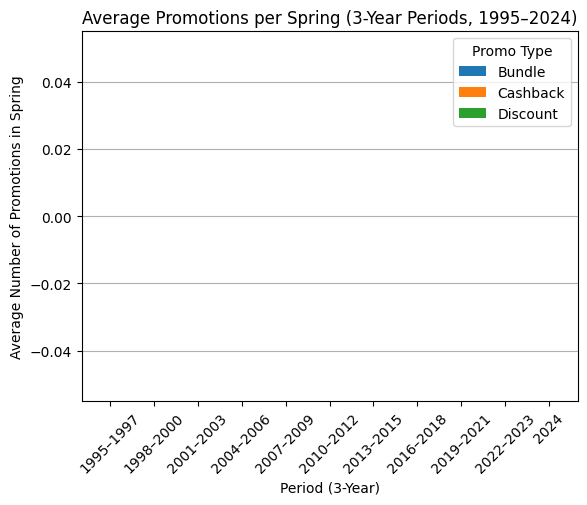

<Figure size 1200x600 with 0 Axes>

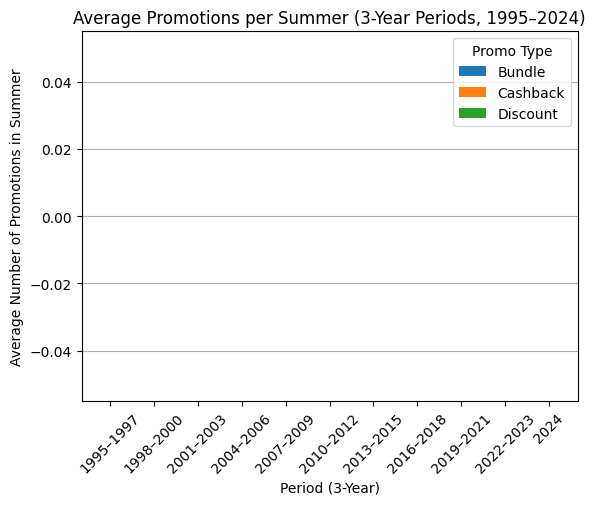

<Figure size 1200x600 with 0 Axes>

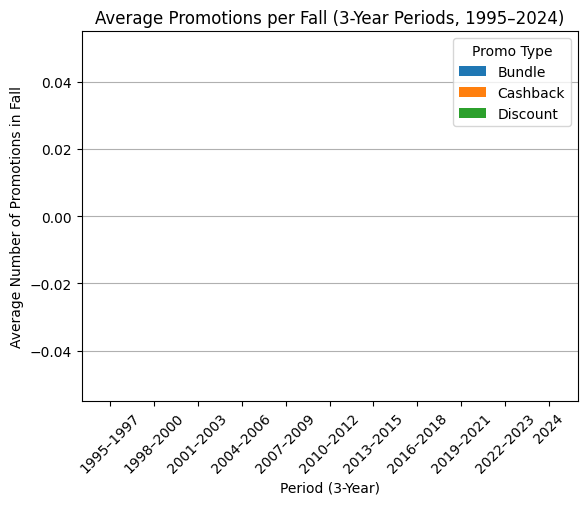


Average Number of Promotions per Season (Bundle, Discount, Cashback) (2-Year Periods, 1995–2024):
 Promo_Type  Season  Bundle  Cashback  Discount
Period_2yr                                    
1995–1996     Fall     0.0       0.0       0.0
1995–1996   Spring     0.0       0.0       0.0
1995–1996   Summer     0.5       0.0       0.0
1995–1996   Winter     0.5       0.0       0.5
1997–1998     Fall     0.5       0.0       0.5
1997–1998   Spring     0.0       0.0       0.0
1997–1998   Summer     0.0       0.0       0.5
1997–1998   Winter     0.0       0.0       0.0
1999–2000     Fall     0.5       0.0       0.0
1999–2000   Spring     1.0       0.0       0.0
1999–2000   Summer     0.0       0.0       1.0
1999–2000   Winter     0.0       0.0       0.0
2001–2002     Fall     0.5       0.0       0.0
2001–2002   Spring     0.0       0.5       0.0
2001–2002   Summer     0.0       0.0       0.0
2001–2002   Winter     0.0       0.0       0.0
2003–2004     Fall     1.0       0.0       0.0
2003–20

<Figure size 1200x600 with 0 Axes>

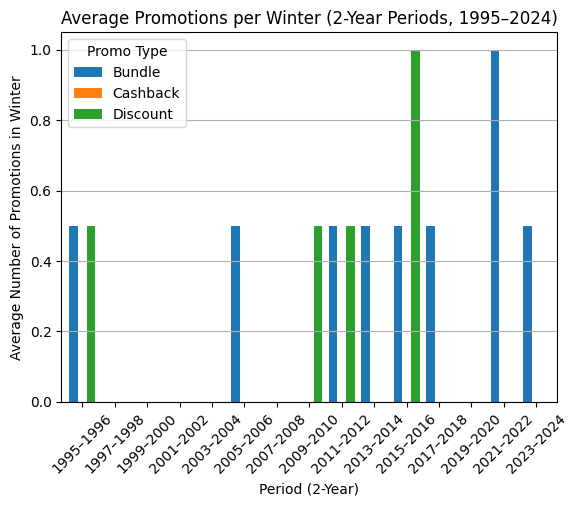

<Figure size 1200x600 with 0 Axes>

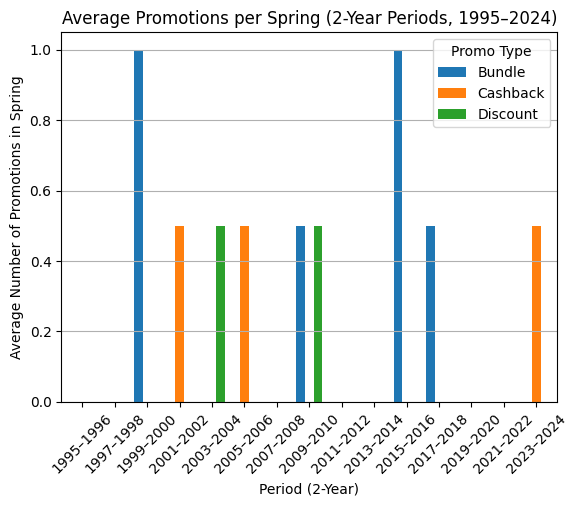

<Figure size 1200x600 with 0 Axes>

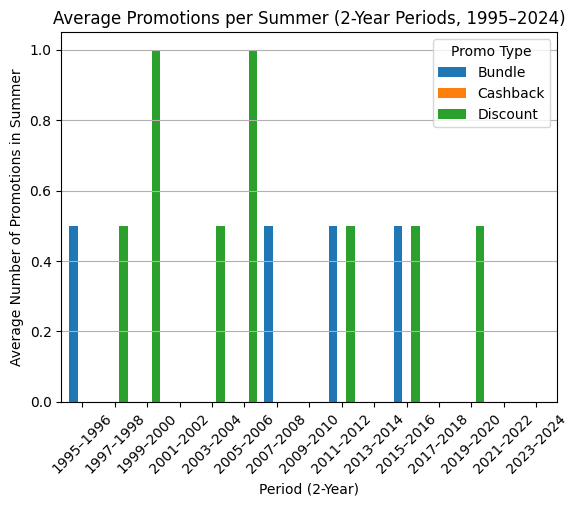

<Figure size 1200x600 with 0 Axes>

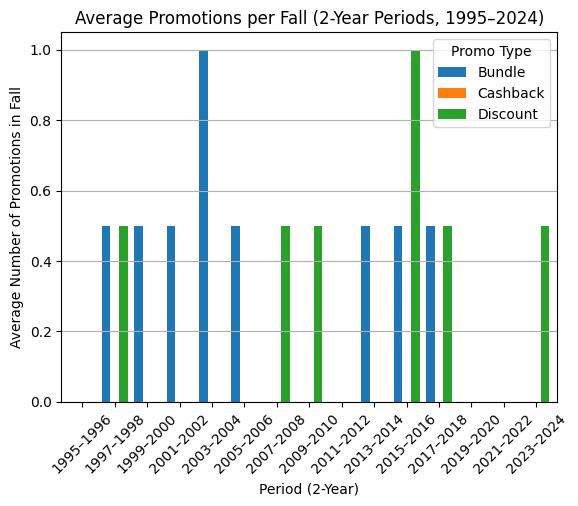

In [58]:
# --- Frequency Analysis of Promotions by Period and Season with Grouped Bar Plots (1995–2024, Excluding Non_Promo) ---

# Lọc dữ liệu từ 1995 đến 2024
df_filtered = merged_df[(merged_df['Year'] >= 1995) & (merged_df['Year'] <= 2024)]

# Loại bỏ Non_Promo
promo_active = df_filtered[df_filtered['Promo_Type'] != 'Non_Promo'].copy()

# Định nghĩa mùa dựa trên Month_Name
season_mapping = {
    'Jan': 'Winter', 'Feb': 'Winter', 'Mar': 'Spring', 'Apr': 'Spring', 'May': 'Spring',
    'Jun': 'Summer', 'Jul': 'Summer', 'Aug': 'Summer', 'Sep': 'Fall', 'Oct': 'Fall',
    'Nov': 'Fall', 'Dec': 'Winter'
}
promo_active['Season'] = promo_active['Month_Name'].map(season_mapping)

# 1. Phân tích tần suất khuyến mãi theo giai đoạn

# --- 5-year periods (1995–1999, 2000–2004, ..., 2020–2024) ---
promo_active['Period_5yr'] = pd.cut(promo_active['Year'],
                                    bins=[1994, 1999, 2004, 2009, 2014, 2019, 2024],
                                    labels=['1995–1999', '2000–2004', '2005–2009', '2010–2014', '2015–2019', '2020–2024'],
                                    include_lowest=True)

# Tần suất theo Promo_Type và giai đoạn 5 năm
freq_5yr = promo_active.groupby(['Period_5yr', 'Promo_Type']).size().unstack().fillna(0)
print("\nTotal Frequency of Promotions (Bundle, Discount, Cashback) by 5-Year Period (1995–2024):\n", freq_5yr)

# Grouped Bar Plot: Tần suất theo giai đoạn 5 năm
plt.figure(figsize=(12, 6))
freq_5yr.plot(kind='bar', width=0.8)
plt.title('Promotion Frequency (Bundle, Discount, Cashback) by 5-Year Period (1995–2024)')
plt.xlabel('Period (5-Year)')
plt.ylabel('Number of Promotions')
plt.xticks(rotation=45)
plt.legend(title='Promo Type')
plt.grid(True, axis='y')
plt.show()

# --- 3-year periods (1995–1997, 1998–2000, ..., 2021–2023, 2024) ---
promo_active['Period_3yr'] = pd.cut(promo_active['Year'],
                                    bins=[1994, 1997, 2000, 2003, 2006, 2009, 2012, 2015, 2018, 2021, 2023, 2024],
                                    labels=['1995–1997', '1998–2000', '2001–2003', '2004–2006', '2007–2009',
                                            '2010–2012', '2013–2015', '2016–2018', '2019–2021', '2022–2023', '2024'],
                                    include_lowest=True)

# Tần suất theo Promo_Type và giai đoạn 3 năm
freq_3yr = promo_active.groupby(['Period_3yr', 'Promo_Type']).size().unstack().fillna(0)
print("\nTotal Frequency of Promotions (Bundle, Discount, Cashback) by 3-Year Period (1995–2024):\n", freq_3yr)

# Grouped Bar Plot: Tần suất theo giai đoạn 3 năm
plt.figure(figsize=(12, 6))
freq_3yr.plot(kind='bar', width=0.8)
plt.title('Promotion Frequency (Bundle, Discount, Cashback) by 3-Year Period (1995–2024)')
plt.xlabel('Period (3-Year)')
plt.ylabel('Number of Promotions')
plt.xticks(rotation=45)
plt.legend(title='Promo Type')
plt.grid(True, axis='y')
plt.show()

# --- 2-year periods (1995–1996, 1997–1998, ..., 2023–2024) ---
promo_active['Period_2yr'] = pd.cut(promo_active['Year'],
                                    bins=[1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014,
                                          2016, 2018, 2020, 2022, 2024],
                                    labels=['1995–1996', '1997–1998', '1999–2000', '2001–2002', '2003–2004',
                                            '2005–2006', '2007–2008', '2009–2010', '2011–2012', '2013–2014',
                                            '2015–2016', '2017–2018', '2019–2020', '2021–2022', '2023–2024'],
                                    include_lowest=True)

# Tần suất theo Promo_Type và giai đoạn 2 năm
freq_2yr = promo_active.groupby(['Period_2yr', 'Promo_Type']).size().unstack().fillna(0)
print("\nTotal Frequency of Promotions (Bundle, Discount, Cashback) by 2-Year Period (1995–2024):\n", freq_2yr)

# Grouped Bar Plot: Tần suất theo giai đoạn 2 năm
plt.figure(figsize=(12, 6))
freq_2yr.plot(kind='bar', width=0.8)
plt.title('Promotion Frequency (Bundle, Discount, Cashback) by 2-Year Period (1995–2024)')
plt.xlabel('Period (2-Year)')
plt.ylabel('Number of Promotions')
plt.xticks(rotation=45)
plt.legend(title='Promo Type')
plt.grid(True, axis='y')
plt.show()

# 2. Phân tích tần suất trung bình theo mùa trong từng giai đoạn

# --- 5-year periods: Seasonal Average ---
seasonal_avg_5yr = promo_active.groupby(['Period_5yr', 'Season', 'Promo_Type'])['Promo_Type'].count().unstack().fillna(0)
# Chia cho số năm trong mỗi giai đoạn (5 năm) để tính trung bình
seasonal_avg_5yr = seasonal_avg_5yr / 5
seasonal_avg_5yr = seasonal_avg_5yr.reset_index().set_index('Period_5yr')
print("\nAverage Number of Promotions per Season (Bundle, Discount, Cashback) (5-Year Periods, 1995–2024):\n", seasonal_avg_5yr)

# Grouped Bar Plot: Tần suất trung bình theo mùa và giai đoạn 5 năm (cho từng mùa)
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    seasonal_data = seasonal_avg_5yr[seasonal_avg_5yr['Season'] == season].drop(columns='Season')
    plt.figure(figsize=(12, 6))
    seasonal_data.plot(kind='bar', width=0.8)
    plt.title(f'Average Promotions per {season} (5-Year Periods, 1995–2024)')
    plt.xlabel('Period (5-Year)')
    plt.ylabel(f'Average Number of Promotions in {season}')
    plt.xticks(rotation=45)
    plt.legend(title='Promo Type')
    plt.grid(True, axis='y')
    plt.show()

# --- 3-year periods: Seasonal Average ---
seasonal_avg_3yr = promo_active.groupby(['Period_3yr', 'Season', 'Promo_Type'])['Promo_Type'].count().unstack().fillna(0)
# Chia cho số năm trong mỗi giai đoạn (3 năm, riêng 2024 là 1 năm)
seasonal_avg_3yr.loc['1995–1997'] = seasonal_avg_3yr.loc['1995–1997'] / 3
seasonal_avg_3yr.loc['1998–2000'] = seasonal_avg_3yr.loc['1998–2000'] / 3
seasonal_avg_3yr.loc['2001–2003'] = seasonal_avg_3yr.loc['2001–2003'] / 3
seasonal_avg_3yr.loc['2004–2006'] = seasonal_avg_3yr.loc['2004–2006'] / 3
seasonal_avg_3yr.loc['2007–2009'] = seasonal_avg_3yr.loc['2007–2009'] / 3
seasonal_avg_3yr.loc['2010–2012'] = seasonal_avg_3yr.loc['2010–2012'] / 3
seasonal_avg_3yr.loc['2013–2015'] = seasonal_avg_3yr.loc['2013–2015'] / 3
seasonal_avg_3yr.loc['2016–2018'] = seasonal_avg_3yr.loc['2016–2018'] / 3
seasonal_avg_3yr.loc['2019–2021'] = seasonal_avg_3yr.loc['2019–2021'] / 3
seasonal_avg_3yr.loc['2022–2023'] = seasonal_avg_3yr.loc['2022–2023'] / 2
seasonal_avg_3yr.loc['2024'] = seasonal_avg_3yr.loc['2024'] / 1
seasonal_avg_3yr = seasonal_avg_3yr.reset_index().set_index('Period_3yr')
print("\nAverage Number of Promotions per Season (Bundle, Discount, Cashback) (3-Year Periods, 1995–2024):\n", seasonal_avg_3yr)

# Grouped Bar Plot: Tần suất trung bình theo mùa và giai đoạn 3 năm (cho từng mùa)
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    seasonal_data = seasonal_avg_3yr[seasonal_avg_3yr['Season'] == season].drop(columns='Season')
    plt.figure(figsize=(12, 6))
    seasonal_data.plot(kind='bar', width=0.8)
    plt.title(f'Average Promotions per {season} (3-Year Periods, 1995–2024)')
    plt.xlabel('Period (3-Year)')
    plt.ylabel(f'Average Number of Promotions in {season}')
    plt.xticks(rotation=45)
    plt.legend(title='Promo Type')
    plt.grid(True, axis='y')
    plt.show()

# --- 2-year periods: Seasonal Average ---
seasonal_avg_2yr = promo_active.groupby(['Period_2yr', 'Season', 'Promo_Type'])['Promo_Type'].count().unstack().fillna(0)
# Chia cho số năm trong mỗi giai đoạn (2 năm)
seasonal_avg_2yr = seasonal_avg_2yr / 2
seasonal_avg_2yr = seasonal_avg_2yr.reset_index().set_index('Period_2yr')
print("\nAverage Number of Promotions per Season (Bundle, Discount, Cashback) (2-Year Periods, 1995–2024):\n", seasonal_avg_2yr)

# Grouped Bar Plot: Tần suất trung bình theo mùa và giai đoạn 2 năm (cho từng mùa)
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    seasonal_data = seasonal_avg_2yr[seasonal_avg_2yr['Season'] == season].drop(columns='Season')
    plt.figure(figsize=(12, 6))
    seasonal_data.plot(kind='bar', width=0.8)
    plt.title(f'Average Promotions per {season} (2-Year Periods, 1995–2024)')
    plt.xlabel('Period (2-Year)')
    plt.ylabel(f'Average Number of Promotions in {season}')
    plt.xticks(rotation=45)
    plt.legend(title='Promo Type')
    plt.grid(True, axis='y')
    plt.show()

In [51]:
temp_df = pd.read_csv('/content/average_monthly_temperature_by_state_1950-2022.csv')
print("Head of Temperature Data:\n", temp_df.head())
print("\nInfo of Temperature Data:\n", temp_df.info())
print("\nDescribe Temperature Data:\n", temp_df.describe())

FileNotFoundError: [Errno 2] No such file or directory: '/content/average_monthly_temperature_by_state_1950-2022.csv'

In [ ]:
# Làm sạch dữ liệu nhiệt độ
# Chuyển đổi cột ngày tháng sang kiểu datetime (YYYY-MM-01)
# Ensure both 'year' and 'month' are treated as strings for concatenation
temp_df['Date'] = pd.to_datetime(temp_df['year'].astype(str) + '-' + temp_df['month'].astype(str) + '-01')

# Kiểm tra và xử lý giá trị thiếu, trùng lặp
print("\nMissing Values in Temperature Data:\n", temp_df.isnull().sum())
print("Duplicates in Temperature Data:", temp_df.duplicated().sum())
temp_df = temp_df.drop_duplicates()
temp_df = temp_df.dropna(subset=['average_temp'])

# Tổng hợp nhiệt độ trung bình toàn quốc
temp_avg = temp_df.groupby('Date')['average_temp'].mean().reset_index()
temp_avg = temp_avg.rename(columns={'average_temp': 'Average_Temperature'})

In [ ]:
# Đặt Date làm index
temp_avg = temp_avg.set_index('Date')

# Hợp nhất dữ liệu nhiệt độ vào merged_df
merged_df = merged_df.reset_index()  # Đặt lại index để có cột Date
merged_df = merged_df.merge(temp_avg, on='Date', how='left')
merged_df = merged_df.set_index('Date')  # Đặt lại Date làm index

# Xử lý giá trị thiếu sau khi hợp nhất (nếu có)
print("\nMissing Values in Average_Temperature after Merge:\n", merged_df['Average_Temperature'].isnull().sum())
merged_df['Average_Temperature'] = merged_df['Average_Temperature'].fillna(merged_df['Average_Temperature'].mean())

# Tạo các đặc trưng độ trễ cho nhiệt độ
merged_df['Temperature_Lag_1'] = merged_df['Average_Temperature'].shift(1)
merged_df['Temperature_Lag_2'] = merged_df['Average_Temperature'].shift(2)

In [ ]:
merged_df.head()

In [ ]:
# B. Phân tích tác động của Nhiệt độ lên Doanh số Sweaters

# Phân tích đơn biến nhiệt độ
# Phân phối (Histogram/KDE, Boxplot)
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['Average_Temperature'], kde=True)
plt.title('Distribution of Average Temperature (1995–2022)')
plt.xlabel('Average Temperature (°F)')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(y=merged_df['Average_Temperature'])
plt.title('Boxplot of Average Temperature (1995–2022)')
plt.ylabel('Average Temperature (°F)')
plt.show()

In [ ]:
# Xu hướng nhiệt độ theo thời gian (Line Plot)
plt.figure(figsize=(15, 6))
plt.plot(merged_df.index, merged_df['Average_Temperature'], color='blue')
plt.title('Average Temperature Over Time (1995–2022)')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°F)')
plt.grid(True)
plt.show()

In [ ]:
# Mẫu hình mùa vụ của nhiệt độ (Line Plot theo tháng)
temp_by_month = merged_df.groupby('Month_Name')['Average_Temperature'].mean().reindex(
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.figure(figsize=(12, 6))
sns.lineplot(x=temp_by_month.index, y=temp_by_month.values)
plt.title('Average Temperature by Month (1995–2022)')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°F)')
plt.grid(True)
plt.show()

In [ ]:
# Phân tích đa biến: Mối quan hệ giữa Nhiệt độ và Doanh số
# Scatter Plot: Sales vs Average_Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average_Temperature', y='New_Sales', data=merged_df)
plt.title('Sales vs Average Temperature (1995–2022)')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Sales (USD)')
plt.grid(True)
plt.show()

In [ ]:
# Hệ số tương quan
correlation = merged_df[['New_Sales', 'Average_Temperature']].corr().iloc[0, 1]
print("\nCorrelation between Sales and Average Temperature:", round(correlation, 3))

In [ ]:
# Tác động của nhiệt độ trễ
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Temperature_Lag_1', y='New_Sales', data=merged_df)
plt.title('Sales vs Temperature_Lag_1')
plt.xlabel('Temperature_Lag_1 (°F)')
plt.ylabel('Sales (USD)')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.scatterplot(x='Temperature_Lag_2', y='New_Sales', data=merged_df)
plt.title('Sales vs Temperature_Lag_2')
plt.xlabel('Temperature_Lag_2 (°F)')
plt.ylabel('Sales (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Tương quan với độ trễ
corr_lag1 = merged_df[['New_Sales', 'Temperature_Lag_1']].corr().iloc[0, 1]
corr_lag2 = merged_df[['New_Sales', 'Temperature_Lag_2']].corr().iloc[0, 1]
print("Correlation between Sales and Temperature_Lag_1:", round(corr_lag1, 3))
print("Correlation between Sales and Temperature_Lag_2:", round(corr_lag2, 3))

In [ ]:
# Tương tác Nhiệt độ và Mùa vụ: Sales và Average_Temperature theo thời gian
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.plot(merged_df.index, merged_df['New_Sales'], color='blue', label='Sales')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df['Average_Temperature'], color='red', label='Temperature')
ax2.set_ylabel('Average Temperature (°F)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.suptitle('Sales and Average Temperature Over Time (1995–2022)')
fig.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Tương tác Nhiệt độ và Khuyến mãi
# Boxplot: Sales theo Is_Promotion, phân tách theo khoảng nhiệt độ
merged_df['Temp_Range'] = pd.cut(merged_df['Average_Temperature'], bins=[0, 40, 50, 60, 70, 80, 100],
                                 labels=['<40°F', '40-50°F', '50-60°F', '60-70°F', '70-80°F', '>80°F'])
plt.figure(figsize=(12, 6))
sns.boxplot(x='Temp_Range', y='New_Sales', hue='Is_Promotion', data=merged_df)
plt.title('Sales by Promotion Status and Temperature Range')
plt.xlabel('Temperature Range (°F)')
plt.ylabel('Sales (USD)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# --- Correlation Analysis: Sales vs Temperature, Budget vs Temperature (2014–2022) ---

# Lọc dữ liệu từ 2014 đến 2022
df_filtered = merged_df[(merged_df['Year'] >= 2014) & (merged_df['Year'] <= 2022)]

# 1. Tương quan giữa Sales và Nhiệt độ
# Tính hệ số tương quan
corr_sales_temp = df_filtered[['New_Sales', 'Average_Temperature']].corr().iloc[0, 1]
print("\nCorrelation between Sales and Average Temperature (2014–2022):", round(corr_sales_temp, 3))

# Scatter Plot: Sales vs Average_Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average_Temperature', y='New_Sales', data=df_filtered)
plt.title('Sales vs Average Temperature (2014–2022)')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Sales (USD)')
plt.grid(True)
plt.show()

# 2. Tương quan giữa Budget và Nhiệt độ
# Tính hệ số tương quan (chỉ xét các tháng có Budget_USD > 0 để có ý nghĩa)
df_promo_filtered = df_filtered[df_filtered['Budget_USD'] > 0]
corr_budget_temp = df_promo_filtered[['Budget_USD', 'Average_Temperature']].corr().iloc[0, 1]
print("\nCorrelation between Budget and Average Temperature (2014–2022, Budget > 0):", round(corr_budget_temp, 3))

# Scatter Plot: Budget_USD vs Average_Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average_Temperature', y='Budget_USD', data=df_promo_filtered)
plt.title('Budget vs Average Temperature (2014–2022, Budget > 0)')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Budget (USD)')
plt.grid(True)
plt.show()

# Ma trận tương quan tổng hợp
corr_cols = ['New_Sales', 'Budget_USD', 'Average_Temperature']
plt.figure(figsize=(8, 6))
sns.heatmap(df_filtered[corr_cols].corr(), annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix: Sales, Budget, and Temperature (2014–2022)')
plt.show()